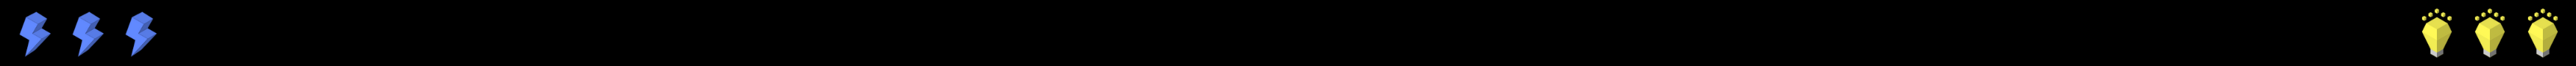

### Import Packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union
from itertools import product
from tqdm.notebook import tqdm
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import datetime

import warnings
warnings.filterwarnings("ignore")

### Data.

Collect form: https://iced.niti.gov.in/energy/electricity/distribution/national-level-consumption/load-curve

In [2]:
%%time
df1 = pd.read_excel("Data/2017-2018.xlsx")
df2 = pd.read_excel("Data/2019-2020.xlsx")
df3 = pd.read_excel("Data/2021-2022.xlsx")
df4 = pd.read_excel("Data/2023-2024.xlsx")

CPU times: total: 3.95 s
Wall time: 4.28 s


In [3]:
df1.head()

,Year,Date,Hourly Demand Met (in MW)
0,2018,01-Jan 12am,112591.48
1,2018,01-Jan 1am,109660.41
2,2018,01-Jan 2am,107696.63
3,2018,01-Jan 3am,106847.56
4,2018,01-Jan 4am,108517.07


Combine all data into single file.

In [4]:
file_paths = glob.glob("Data/*.xlsx")
dataframes = [pd.read_excel(file) for file in file_paths]
combined_data = pd.concat(dataframes, ignore_index=True)

In [5]:
dataset = combined_data

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64248 entries, 0 to 64247
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       64248 non-null  int64  
 1   Date                       64248 non-null  object 
 2   Hourly Demand Met (in MW)  64248 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


Concat year and date column into a single column called "Timestamp".

In [7]:
dataset['Timestamp'] = dataset['Year'].astype(str) + "-" + dataset['Date'].astype(str)

In [8]:
dataset.head()

,Year,Date,Hourly Demand Met (in MW),Timestamp
0,2018,01-Jan 12am,112591.48,2018-01-Jan 12am
1,2018,01-Jan 1am,109660.41,2018-01-Jan 1am
2,2018,01-Jan 2am,107696.63,2018-01-Jan 2am
3,2018,01-Jan 3am,106847.56,2018-01-Jan 3am
4,2018,01-Jan 4am,108517.07,2018-01-Jan 4am


In [9]:
dataset = dataset.drop(columns = ['Year', 'Date'])

In [10]:
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])
dataset.dtypes

Hourly Demand Met (in MW)           float64
Timestamp                    datetime64[ns]
dtype: object

In [11]:
dataset.duplicated().sum()

np.int64(0)

In [12]:
dataset.shape

(64248, 2)

In [13]:
max_timestamp = dataset['Timestamp'].max()
min_timestamp = dataset['Timestamp'].min()
max_timestamp, min_timestamp

(Timestamp('2024-04-30 23:00:00'), Timestamp('2017-01-01 00:00:00'))

In [14]:
custom_timestamp = pd.date_range(start = min_timestamp, end = max_timestamp, freq = 'h')
custom_timestamp = pd.DataFrame(custom_timestamp, columns = ['Timestamp'])
custom_timestamp

,Timestamp
0,2017-01-01 00:00:00
1,2017-01-01 01:00:00
2,2017-01-01 02:00:00
3,2017-01-01 03:00:00
4,2017-01-01 04:00:00
...,...
64243,2024-04-30 19:00:00
64244,2024-04-30 20:00:00
64245,2024-04-30 21:00:00
64246,2024-04-30 22:00:00


In [15]:
dataset = custom_timestamp.merge(dataset, on = 'Timestamp', how = 'left')
dataset.shape

(64248, 2)

In [16]:
dataset.head()

,Timestamp,Hourly Demand Met (in MW)
0,2017-01-01 00:00:00,108985.17
1,2017-01-01 01:00:00,105856.08
2,2017-01-01 02:00:00,103115.75
3,2017-01-01 03:00:00,102407.04
4,2017-01-01 04:00:00,104235.34


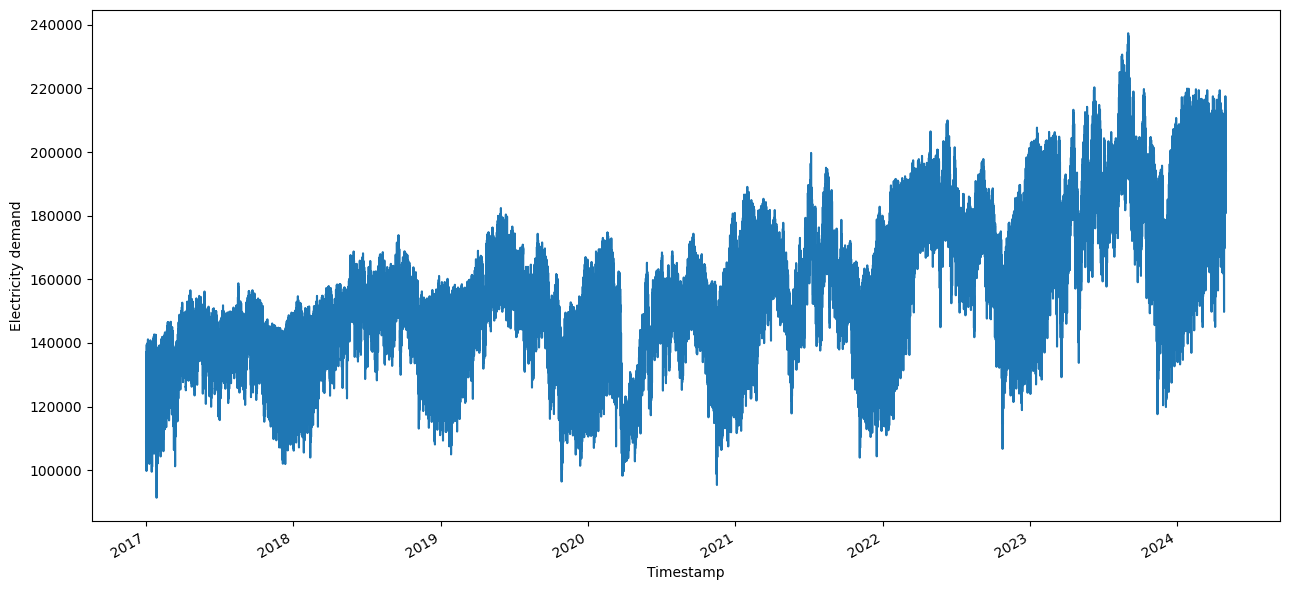

In [17]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(dataset['Timestamp'], dataset['Hourly Demand Met (in MW)'])
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity demand')

fig.autofmt_xdate()
plt.tight_layout()

### Start with baseline model on sample data.

#### Baseline model.

Let first start with simple baseline model on just 1000 sample and predict 100 points. Start with mean value, last value and last 100 session for prediction.

In [18]:
baseline_train = dataset[:1000]
baseline_test = dataset[1000:1100]

In [19]:
baseline_train.head()

,Timestamp,Hourly Demand Met (in MW)
0,2017-01-01 00:00:00,108985.17
1,2017-01-01 01:00:00,105856.08
2,2017-01-01 02:00:00,103115.75
3,2017-01-01 03:00:00,102407.04
4,2017-01-01 04:00:00,104235.34


In [20]:
historical_baseline_mean = baseline_train['Hourly Demand Met (in MW)'].mean()
historical_baseline_mean

np.float64(124990.46753)

In [21]:
baseline_test = baseline_test.copy()
baseline_test.loc[:, 'pred_mean'] = historical_baseline_mean
baseline_test

,Timestamp,Hourly Demand Met (in MW),pred_mean
1000,2017-02-11 16:00:00,132049.67,124990.46753
1001,2017-02-11 17:00:00,132699.66,124990.46753
1002,2017-02-11 18:00:00,136494.41,124990.46753
1003,2017-02-11 19:00:00,139043.27,124990.46753
1004,2017-02-11 20:00:00,132069.83,124990.46753
...,...,...,...
1095,2017-02-15 15:00:00,132542.36,124990.46753
1096,2017-02-15 16:00:00,133728.64,124990.46753
1097,2017-02-15 17:00:00,134944.64,124990.46753
1098,2017-02-15 18:00:00,139884.54,124990.46753


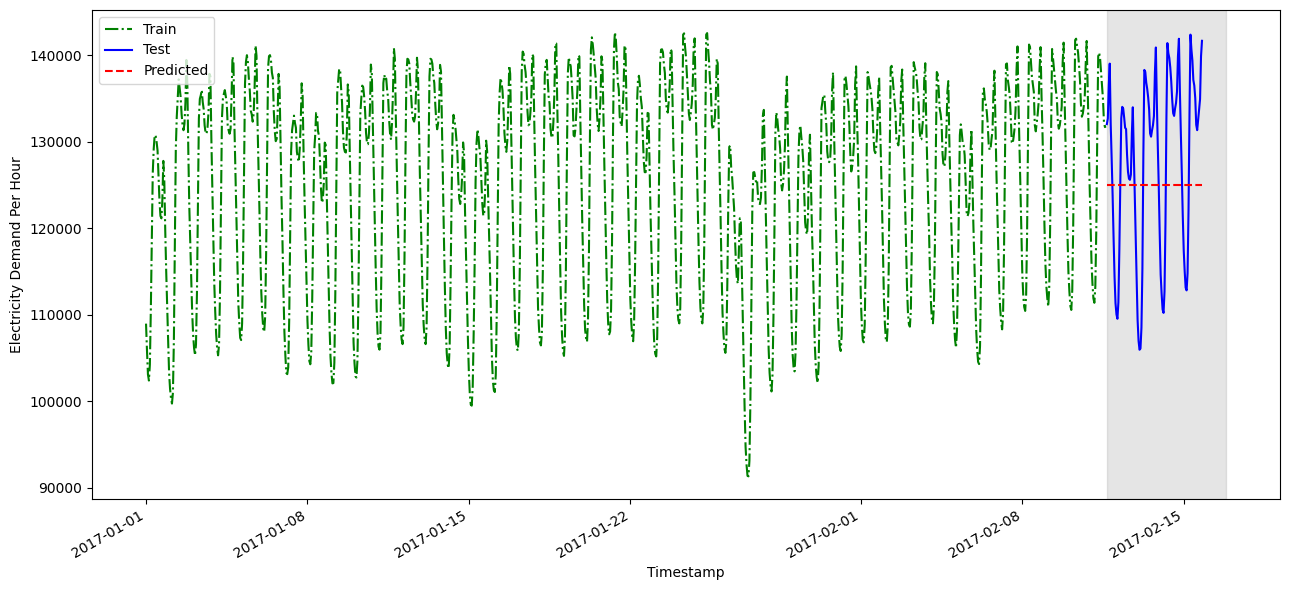

In [22]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(baseline_train['Timestamp'], baseline_train['Hourly Demand Met (in MW)'], 'g-.', label='Train')
ax.plot(baseline_test['Timestamp'], baseline_test['Hourly Demand Met (in MW)'], 'b-', label='Test')
ax.plot(baseline_test['Timestamp'], baseline_test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity Demand Per Hour')
ax.axvspan(pd.Timestamp('2017-02-11 16:00:00'), pd.Timestamp('2017-02-16 20:00:00'), color='#808080', alpha=0.2)
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [23]:
def mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [24]:
baseline_mape = mape(baseline_test['Hourly Demand Met (in MW)'], baseline_test['pred_mean'])
baseline_mape

np.float64(0.07498243852962791)

In [25]:
historical_lasthours_mean = baseline_train.loc[976 : 1000, 'Hourly Demand Met (in MW)'].mean()
historical_lasthours_mean

np.float64(129391.76291666667)

In [26]:
baseline_test.loc[:, 'lasthours_pred_mean'] = historical_lasthours_mean
baseline_test

,Timestamp,Hourly Demand Met (in MW),pred_mean,lasthours_pred_mean
1000,2017-02-11 16:00:00,132049.67,124990.46753,129391.762917
1001,2017-02-11 17:00:00,132699.66,124990.46753,129391.762917
1002,2017-02-11 18:00:00,136494.41,124990.46753,129391.762917
1003,2017-02-11 19:00:00,139043.27,124990.46753,129391.762917
1004,2017-02-11 20:00:00,132069.83,124990.46753,129391.762917
...,...,...,...,...
1095,2017-02-15 15:00:00,132542.36,124990.46753,129391.762917
1096,2017-02-15 16:00:00,133728.64,124990.46753,129391.762917
1097,2017-02-15 17:00:00,134944.64,124990.46753,129391.762917
1098,2017-02-15 18:00:00,139884.54,124990.46753,129391.762917


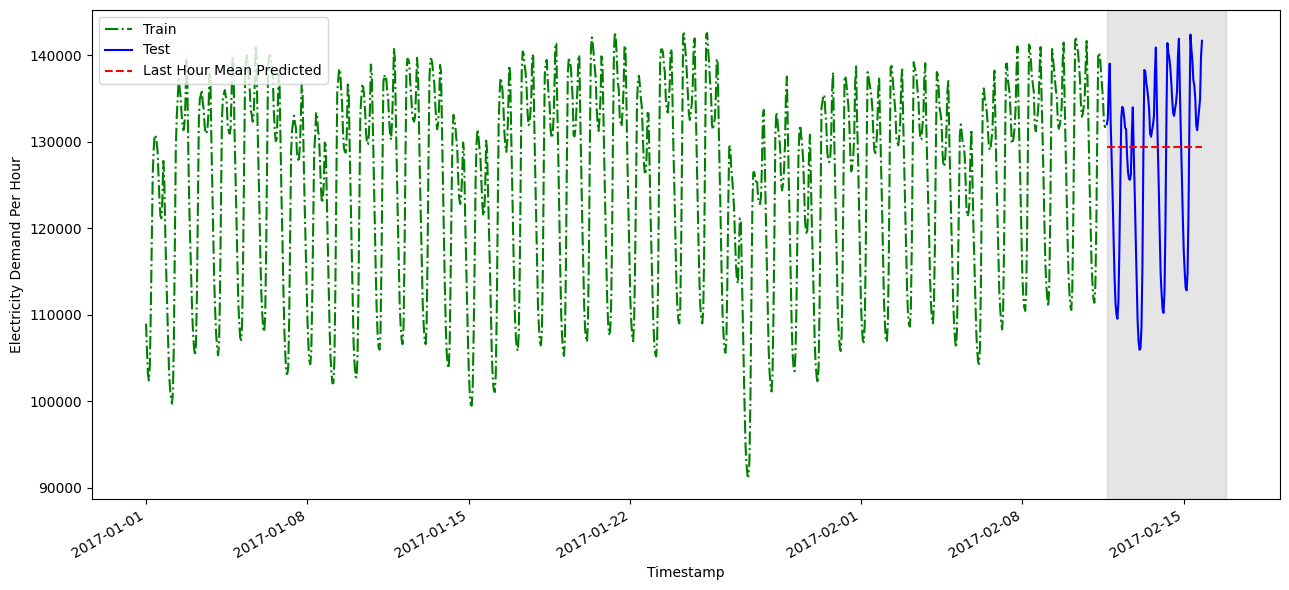

In [27]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(baseline_train['Timestamp'], baseline_train['Hourly Demand Met (in MW)'], 'g-.', label='Train')
ax.plot(baseline_test['Timestamp'], baseline_test['Hourly Demand Met (in MW)'], 'b-', label='Test')
ax.plot(baseline_test['Timestamp'], baseline_test['lasthours_pred_mean'], 'r--', label='Last Hour Mean Predicted')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity Demand Per Hour')
ax.axvspan(pd.Timestamp('2017-02-11 16:00:00'), pd.Timestamp('2017-02-16 20:00:00'), color='#808080', alpha=0.2)
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [28]:
baseline_lasthour_mape = mape(baseline_test['Hourly Demand Met (in MW)'], baseline_test['lasthours_pred_mean'])
baseline_lasthour_mape

np.float64(0.06876529206715612)

In [29]:
baseline_test.loc[:, 'lasthours_pred_season'] = baseline_train['Hourly Demand Met (in MW)'][900 : 1000].values
baseline_test

,Timestamp,Hourly Demand Met (in MW),pred_mean,lasthours_pred_mean,lasthours_pred_season
1000,2017-02-11 16:00:00,132049.67,124990.46753,129391.762917,132881.66
1001,2017-02-11 17:00:00,132699.66,124990.46753,129391.762917,129955.84
1002,2017-02-11 18:00:00,136494.41,124990.46753,129391.762917,129805.65
1003,2017-02-11 19:00:00,139043.27,124990.46753,129391.762917,130597.44
1004,2017-02-11 20:00:00,132069.83,124990.46753,129391.762917,131610.99
...,...,...,...,...,...
1095,2017-02-15 15:00:00,132542.36,124990.46753,129391.762917,136423.18
1096,2017-02-15 16:00:00,133728.64,124990.46753,129391.762917,134859.44
1097,2017-02-15 17:00:00,134944.64,124990.46753,129391.762917,132199.44
1098,2017-02-15 18:00:00,139884.54,124990.46753,129391.762917,131707.65


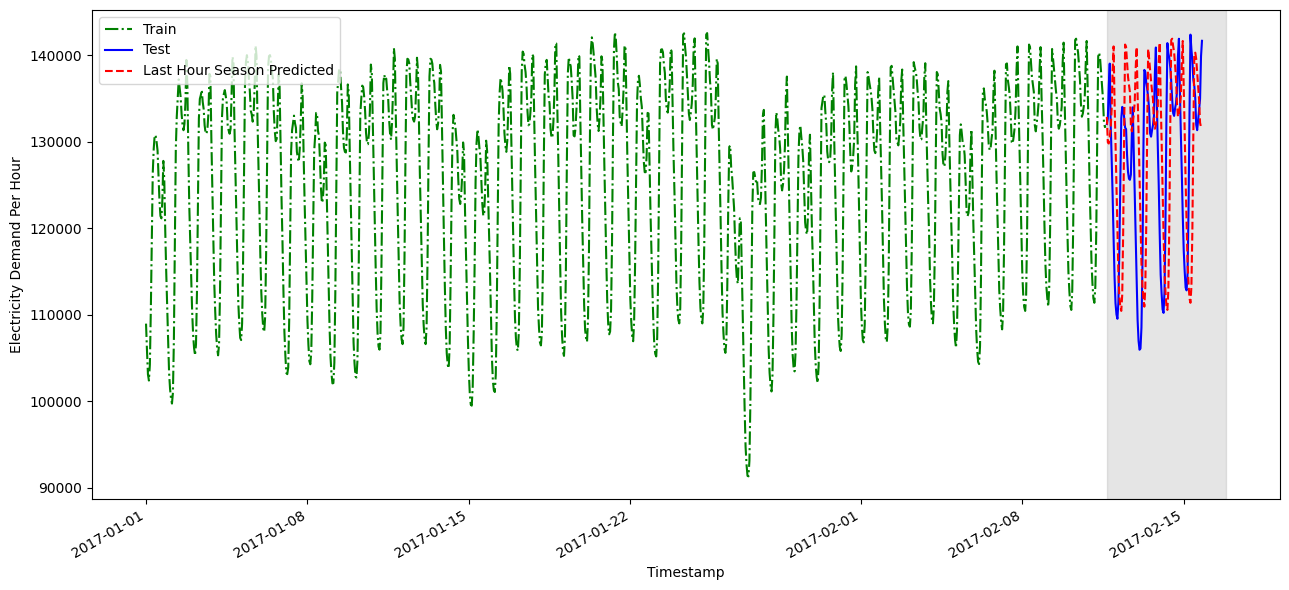

In [30]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(baseline_train['Timestamp'], baseline_train['Hourly Demand Met (in MW)'], 'g-.', label='Train')
ax.plot(baseline_test['Timestamp'], baseline_test['Hourly Demand Met (in MW)'], 'b-', label='Test')
ax.plot(baseline_test['Timestamp'], baseline_test['lasthours_pred_season'], 'r--', label='Last Hour Season Predicted')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Electricity Demand Per Hour')
ax.axvspan(pd.Timestamp('2017-02-11 16:00:00'), pd.Timestamp('2017-02-16 20:00:00'), color='#808080', alpha=0.2)
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [31]:
baseline_lastseason_mape = mape(baseline_test['Hourly Demand Met (in MW)'], baseline_test['lasthours_pred_season'])
baseline_lastseason_mape

np.float64(0.08774178669139139)

In [32]:
baseline_mape, baseline_lasthour_mape, baseline_lastseason_mape

(np.float64(0.07498243852962791),
 np.float64(0.06876529206715612),
 np.float64(0.08774178669139139))

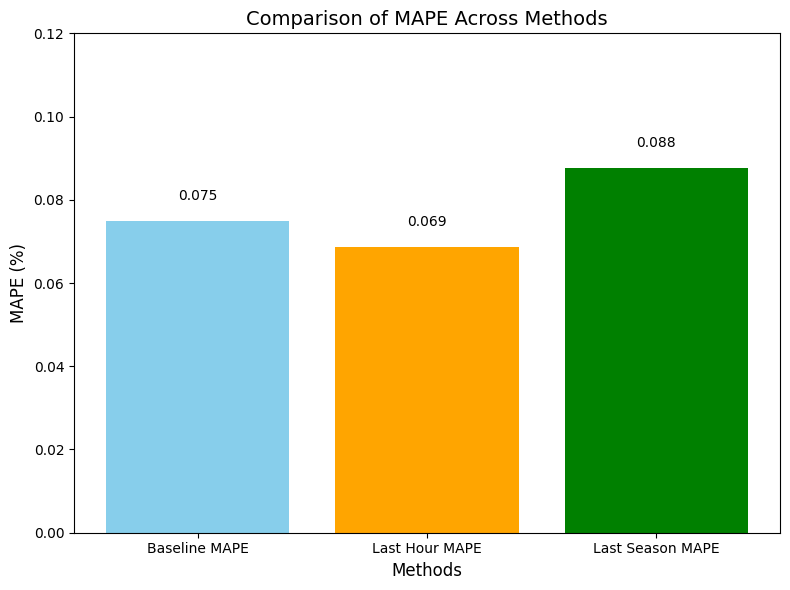

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

x = ['Baseline MAPE', 'Last Hour MAPE', 'Last Season MAPE']  # Fixed duplicate label
y = [baseline_mape, baseline_lasthour_mape, baseline_lastseason_mape]

# Create a bar plot
ax.bar(x, y, color=['skyblue', 'orange', 'green'])
ax.set_xlabel('Methods', fontsize=12)
ax.set_ylabel('MAPE (%)', fontsize=12)
ax.set_ylim(0, 0.12)  # Adjust the y-axis limit as needed
ax.set_title('Comparison of MAPE Across Methods', fontsize=14)

# Annotate the bar plot with values
for index, value in enumerate(y):
    ax.text(x=index, y=value + 0.005, s=f"{value:.2}", ha='center', fontsize=10)  # Corrected formatting

plt.tight_layout()
plt.show()

In [60]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if  method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            mean = df[:i].iloc[-1].values[0]
            pred_last_value.extend(mean for _ in range(window))
        return pred_last_value

    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order = (0, 0, 24))
            res = model.fit(disp = False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA    

    elif method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(25,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        return pred_AR

    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(24,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA
        
    elif method == 'ARIMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(24,1,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

#### Moving average model.

In [36]:
MA_dataset = dataset['Hourly Demand Met (in MW)'][0:1101]
MA_dataset.head()

0    108985.17
1    105856.08
2    103115.75
3    102407.04
4    104235.34
Name: Hourly Demand Met (in MW), dtype: float64

In [37]:
MA_dataset = MA_dataset.values
ADF_result = adfuller(MA_dataset)
print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistics: -1.8957552048381892
p-value: 0.33406062378881873


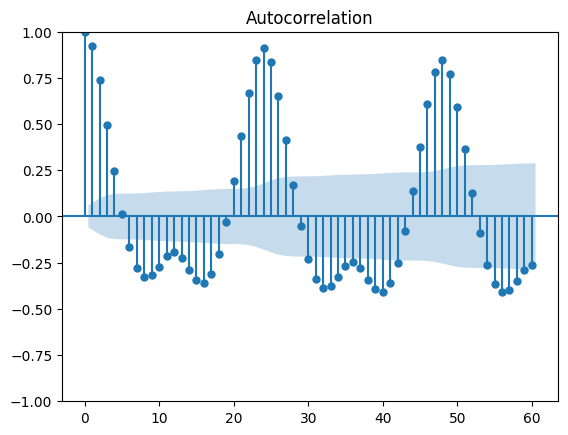

In [38]:
plot_acf(MA_dataset, lags = 60)
plt.show()

In [39]:
MA_dataset.shape

(1101,)

In [40]:
MA_dataset_diff = np.diff(MA_dataset, n = 1)
ADF_result = adfuller(MA_dataset_diff)
print(f'ADF Statistics: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistics: -10.654258375917298
p-value: 4.577247727960203e-19


In [41]:
MA_dataset_diff = pd.DataFrame({'Hourly Demand Met (in MW) diff' : MA_dataset_diff})
MA_dataset_diff.shape

(1100, 1)

In [42]:
MA_train_diff = MA_dataset_diff[:1000] 
MA_test_diff = MA_dataset_diff[1000:]

In [43]:
pred_df = MA_test_diff.copy()
TRAIN_LEN = len(MA_train_diff)
HORIZON = len(MA_test_diff)
WINDOW = 1

pred_mean = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

In [44]:
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA
pred_df.head()

,Hourly Demand Met (in MW) diff,pred_mean,pred_last_value,pred_MA
1000,649.99,23.064500,246.53,1235.988804
1001,3794.75,23.690799,649.99,2319.841926
1002,2548.86,27.454331,3794.75,2621.949137
1003,-6973.44,29.968195,2548.86,-2150.097738
1004,-4028.92,22.992689,-6973.44,-5458.790631


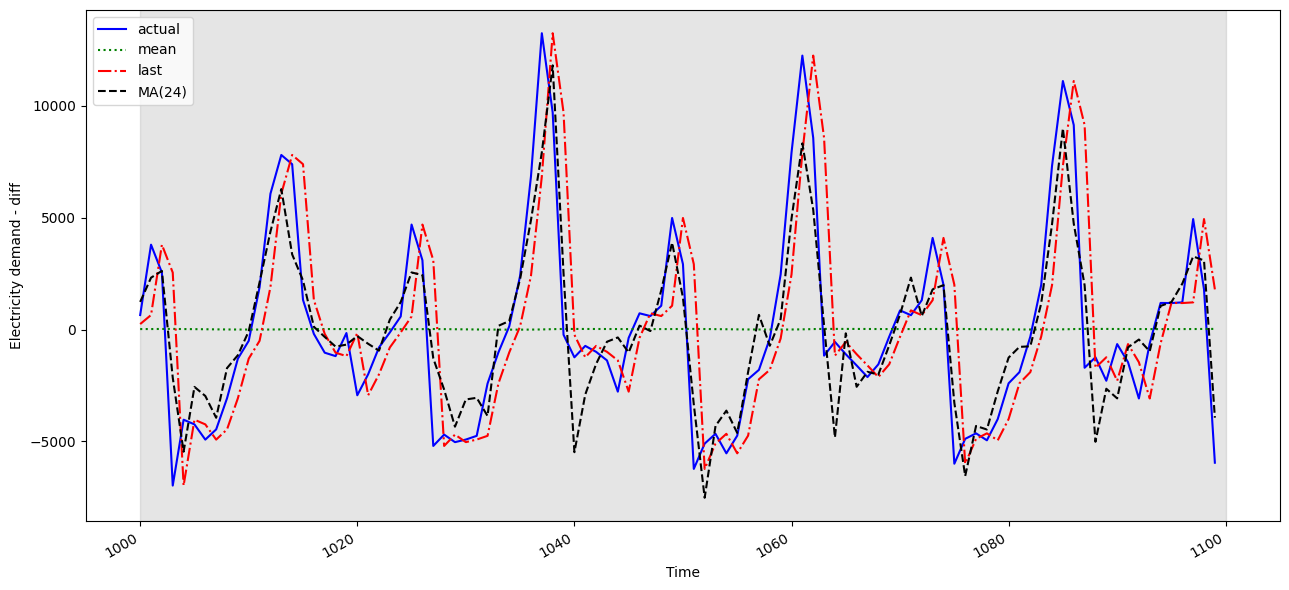

In [45]:
fig, ax = plt.subplots(figsize = (13, 6))

ax.plot(pred_df['Hourly Demand Met (in MW) diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(24)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Electricity demand - diff')

ax.axvspan(1000, 1100, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

In [46]:
mse_mean = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_MA'])
print(mse_mean, mse_last, mse_MA)

18270836.92975346 11195406.719030999 3734229.1852337257


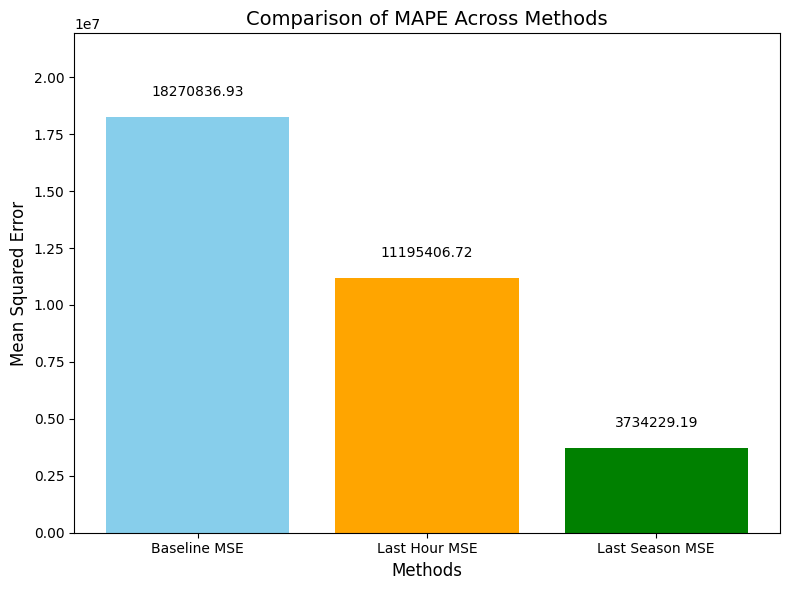

In [47]:
# Initialize plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# Data for the plot
x = ['Baseline MSE', 'Last Hour MSE', 'Last Season MSE']
y = [mse_mean, mse_last, mse_MA]

# Create a bar plot
ax.bar(x, y, color=['skyblue', 'orange', 'green'])
ax.set_xlabel('Methods', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12)
ax.set_ylim(0, max(y) * 1.2)  # Dynamically set y-axis limit
ax.set_title('Comparison of MAPE Across Methods', fontsize=14)

# Annotate the bar plot with values
for index, value in enumerate(y):
    ax.text(index, value + (max(y) * 0.05), s=f"{value:.2f}", ha='center', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### Autoregressive Model.

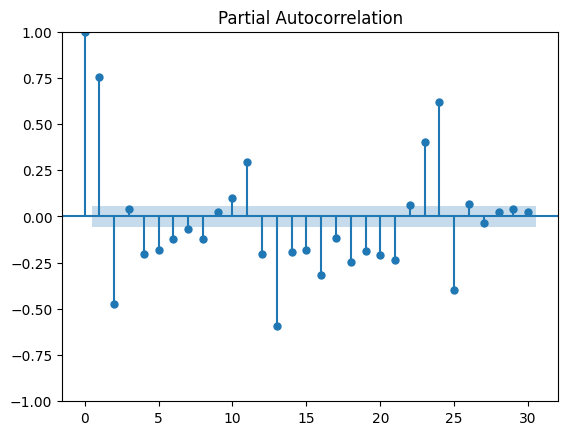

In [48]:
plot_pacf(MA_dataset_diff, lags = 30)
plt.show()

In [49]:
pred_AR = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')

In [50]:
pred_df['pred_AR'] = pred_AR
pred_df.head()

,Hourly Demand Met (in MW) diff,pred_mean,pred_last_value,pred_MA,pred_AR
1000,649.99,23.064500,246.53,1235.988804,1074.426401
1001,3794.75,23.690799,649.99,2319.841926,3766.858186
1002,2548.86,27.454331,3794.75,2621.949137,2566.126549
1003,-6973.44,29.968195,2548.86,-2150.097738,-4838.635282
1004,-4028.92,22.992689,-6973.44,-5458.790631,-6225.871023


In [52]:
mse_AR = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_AR'])
mse_AR

np.float64(874029.3578130299)

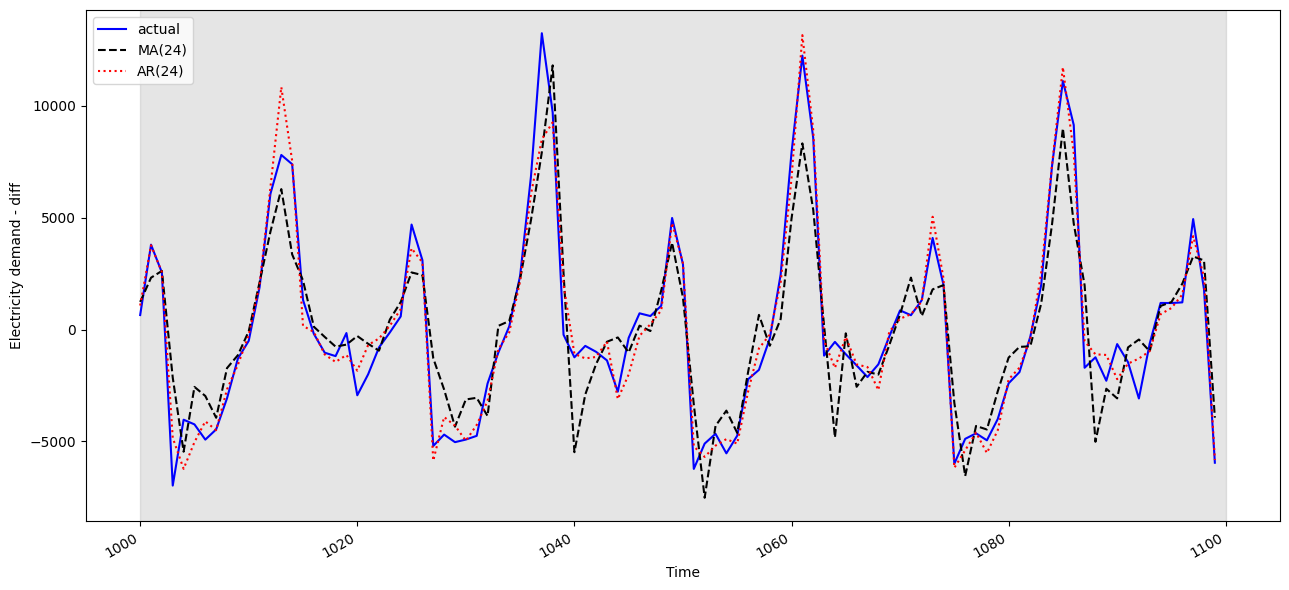

In [53]:
fig, ax = plt.subplots(figsize = (13, 6))

ax.plot(pred_df['Hourly Demand Met (in MW) diff'], 'b-', label='actual')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(24)')
ax.plot(pred_df['pred_AR'], 'r:', label='AR(24)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Electricity demand - diff')

ax.axvspan(1000, 1100, color='#808080', alpha=0.2)

fig.autofmt_xdate()
plt.tight_layout()

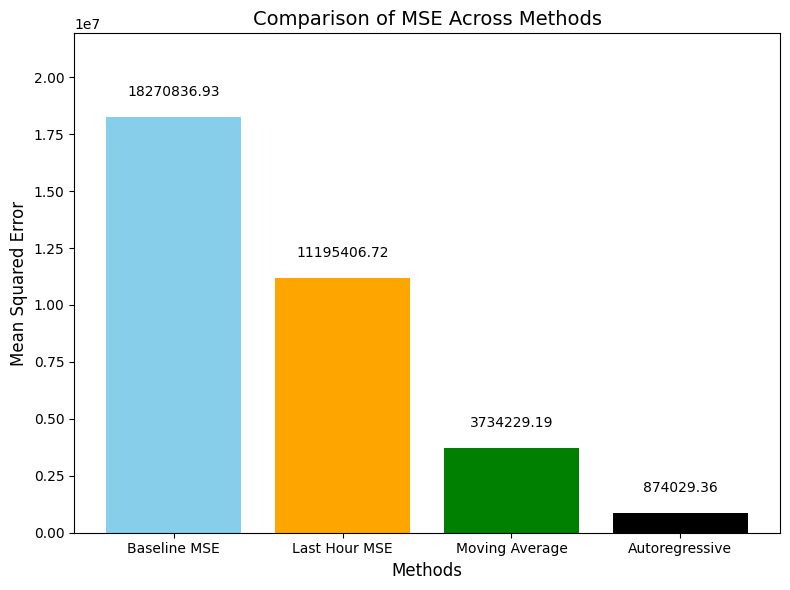

In [54]:
# Initialize plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# Data for the plot
x = ['Baseline MSE', 'Last Hour MSE', 'Moving Average', 'Autoregressive']
y = [mse_mean, mse_last, mse_MA, mse_AR]

# Create a bar plot
ax.bar(x, y, color=['skyblue', 'orange', 'green', 'black'])
ax.set_xlabel('Methods', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12)
ax.set_ylim(0, max(y) * 1.2)  # Dynamically set y-axis limit
ax.set_title('Comparison of MSE Across Methods', fontsize=14)

# Annotate the bar plot with values
for index, value in enumerate(y):
    ax.text(index, value + (max(y) * 0.05), s=f"{value:.2f}", ha='center', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### ARMA Model.

In [55]:
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [56]:
ps = range(0, 25, 1)
qs = range(0, 8, 1)
order_list = list(product(ps, qs))

In [57]:
result_df = optimize_ARMA(MA_train_diff, order_list)
result_df

  0%|          | 0/200 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(24, 2)",16323.415442
1,"(24, 1)",16323.473609
2,"(24, 5)",16325.017462
3,"(24, 4)",16325.305291
4,"(24, 3)",16325.399971
...,...,...
195,"(0, 2)",18636.883610
196,"(1, 0)",18800.605637
197,"(0, 7)",18832.132578
198,"(0, 1)",18855.231838


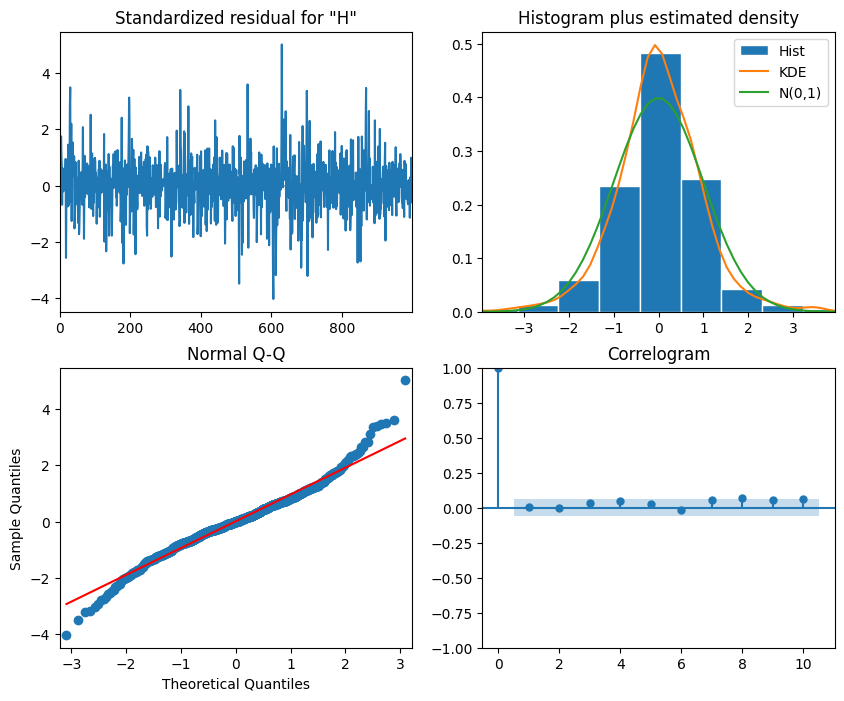

In [58]:
model = SARIMAX(MA_train_diff, order=(24,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [59]:
residuals = model_fit.resid
sm.stats.acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)

,lb_stat,lb_pvalue
1,0.624425,0.429408
2,0.700492,0.704515
3,1.618820,0.655130
4,2.244943,0.690810
5,2.407607,0.790341
6,2.665952,0.849452
7,5.280267,0.625803
8,8.353612,0.399712
9,11.409296,0.248693
10,13.627906,0.190650


In [ ]:
pred_ARMA = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

In [57]:
pred_df['pred_ARMA'] = pred_ARMA
pred_df.head(10)

,Hourly Demand Met (in MW) diff,pred_mean,pred_last_value,pred_MA,pred_AR,pred_ARMA
1000,649.99,23.064500,246.53,177.581668,1074.426401,971.942529
1001,3794.75,23.690799,649.99,539.360638,3766.858186,3751.519687
1002,2548.86,27.454331,3794.75,4193.832489,2566.126549,2566.174898
1003,-6973.44,29.968195,2548.86,515.646830,-4838.635282,-4925.362449
1004,-4028.92,22.992689,-6973.44,-9131.397540,-6225.871023,-6099.590802
1005,-4238.26,18.960935,-4028.92,217.088878,-5032.496117,-5055.320134
1006,-4919.37,14.729105,-4238.26,-3420.698607,-4103.049138,-4342.012265
1007,-4462.51,9.829305,-4919.37,-3578.422525,-4496.444156,-4655.098708
1008,-3070.47,5.392460,-4462.51,-3157.947990,-2670.251917,-2600.246868
1009,-1298.93,2.344034,-3070.47,-883.789579,-1578.354737,-1463.151348


In [58]:
mse_ARMA = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_ARMA'])
mse_ARMA

np.float64(817721.1089540538)

In [59]:
mse_ARMA = mape(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_ARMA'])
mse_ARMA

np.float64(-0.28989280161837794)

In [60]:
MA_dataset = dataset['Hourly Demand Met (in MW)'][0:1101]
MA_dataset.head()

0    108985.17
1    105856.08
2    103115.75
3    102407.04
4    104235.34
Name: Hourly Demand Met (in MW), dtype: float64

In [61]:
MA_dataset = dataset['Hourly Demand Met (in MW)'][0:1100].copy()
MA_dataset.tail()

1095    132542.36
1096    133728.64
1097    134944.64
1098    139884.54
1099    141681.55
Name: Hourly Demand Met (in MW), dtype: float64

In [62]:
MA_dataset = pd.DataFrame(MA_dataset, columns = ['Hourly Demand Met (in MW)'])
MA_dataset

,Hourly Demand Met (in MW)
0,108985.17
1,105856.08
2,103115.75
3,102407.04
4,104235.34
...,...
1095,132542.36
1096,133728.64
1097,134944.64
1098,139884.54


In [63]:
pred_df.shape, MA_dataset.shape

((100, 6), (1100, 1))

In [64]:
MA_dataset.loc[1000:, 'pred_demand'] = (
    MA_dataset['Hourly Demand Met (in MW)'].iloc[1000] + pred_df['pred_ARMA'].cumsum().values
)

In [65]:
MA_dataset[1000:]

,Hourly Demand Met (in MW),pred_demand
1000,132049.67,133021.612529
1001,132699.66,136773.132216
1002,136494.41,139339.307114
1003,139043.27,134413.944665
1004,132069.83,128314.353863
...,...,...
1095,132542.36,132373.367425
1096,133728.64,133677.800311
1097,134944.64,137801.460954
1098,139884.54,140362.450357


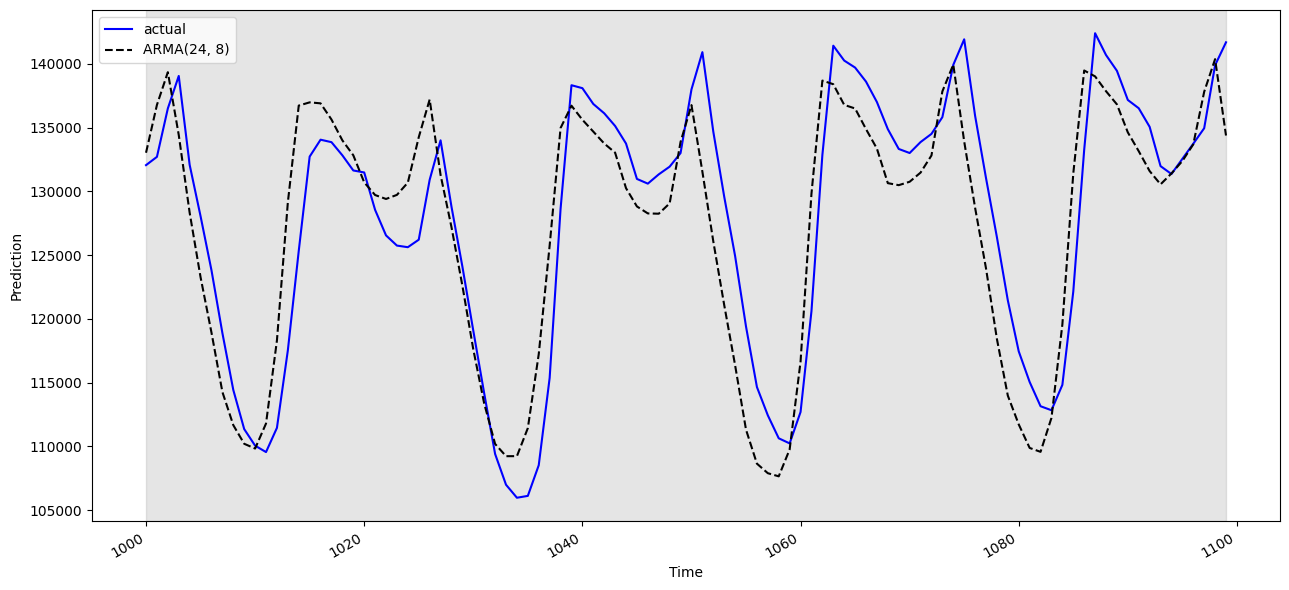

In [66]:
fig, ax = plt.subplots(figsize = (13, 6))
ax.plot(MA_dataset['Hourly Demand Met (in MW)'][1000:], 'b-', label='actual')
ax.plot(MA_dataset['pred_demand'], 'k--', label='ARMA(24, 8)')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Prediction')
ax.axvspan(1000, 1099, color='#808080', alpha=0.2)
# ax.set_xlim(400, 500)
# plt.xticks(
# [409, 439, 468, 498],
# ['Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

In [67]:
mse_ARMA = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_ARMA'])
mse_ARMA

np.float64(817721.1089540538)

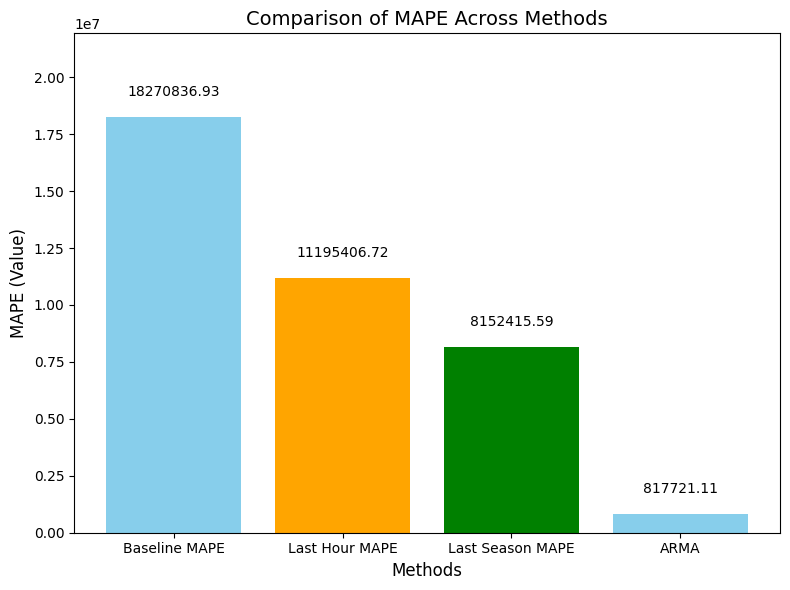

In [68]:
# Initialize plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# Data for the plot
x = ['Baseline MAPE', 'Last Hour MAPE', 'Last Season MAPE', 'ARMA']
y = [mse_mean, mse_last, mse_MA, mse_ARMA]

# Create a bar plot
ax.bar(x, y, color=['skyblue', 'orange', 'green'])
ax.set_xlabel('Methods', fontsize=12)
ax.set_ylabel('MAPE (Value)', fontsize=12)
ax.set_ylim(0, max(y) * 1.2)  # Dynamically set y-axis limit
ax.set_title('Comparison of MAPE Across Methods', fontsize=14)

# Annotate the bar plot with values
for index, value in enumerate(y):
    ax.text(index, value + (max(y) * 0.05), s=f"{value:.2f}", ha='center', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [69]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    result = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order = (order[0], d, order[1]), simple_differencing = False).fit(disp = False)
        except:
            continue
        aic = model.aic
        result.append([order, aic])

    result_df = pd.DataFrame(result)
    result_df.columns = ['(p,q)', 'AIC']

    result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)
    return result_df

In [70]:
# ps = range(0, 25, 1)
# qs = range(0, 12, 1)
# d = 1
# order_list = list(product(ps, qs))

In [71]:
# result_df = optimize_ARIMA(MA_train_diff, order_list, d)
# result_df

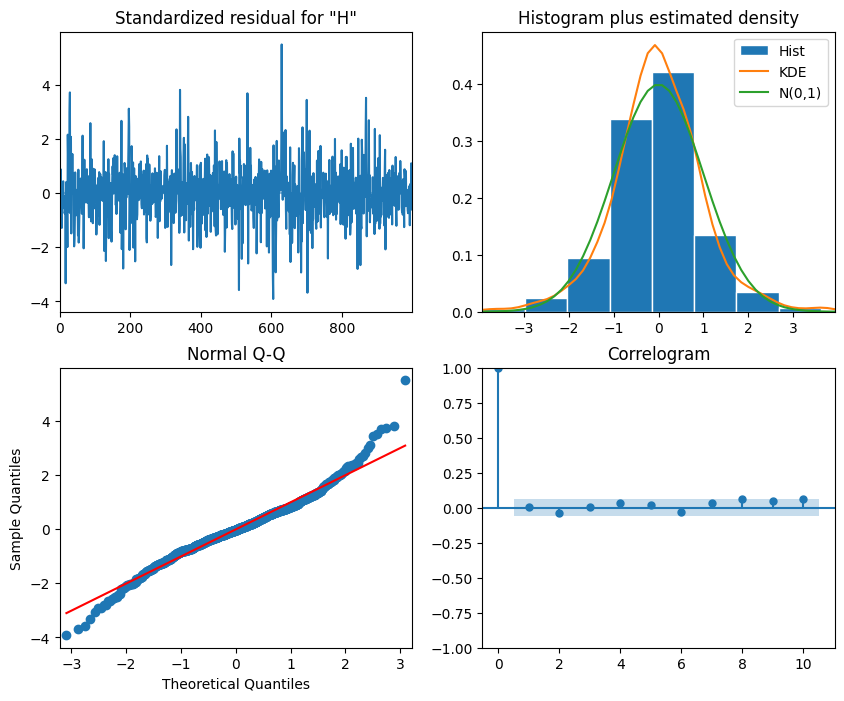

In [72]:
model = SARIMAX(MA_train_diff, order=(24,1,0), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8))
plt.show()

In [73]:
residuals = model_fit.resid
sm.stats.acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)

,lb_stat,lb_pvalue
1,0.244697,0.620834
2,0.963010,0.617853
3,1.071982,0.783842
4,1.633113,0.802829
5,2.329879,0.801869
6,3.354702,0.763190
7,5.270849,0.626948
8,8.352527,0.399813
9,13.208963,0.153377
10,15.535639,0.113719


In [74]:
pred_ARIMA = rolling_forecast(MA_dataset_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

In [75]:
pred_df['pred_ARIMA'] = pred_ARIMA
pred_df.head(10)

,Hourly Demand Met (in MW) diff,pred_mean,pred_last_value,pred_MA,pred_AR,pred_ARMA,pred_ARIMA
1000,649.99,23.064500,246.53,177.581668,1074.426401,971.942529,1024.780823
1001,3794.75,23.690799,649.99,539.360638,3766.858186,3751.519687,3702.023593
1002,2548.86,27.454331,3794.75,4193.832489,2566.126549,2566.174898,2501.001301
1003,-6973.44,29.968195,2548.86,515.646830,-4838.635282,-4925.362449,-4919.785579
1004,-4028.92,22.992689,-6973.44,-9131.397540,-6225.871023,-6099.590802,-6350.300772
1005,-4238.26,18.960935,-4028.92,217.088878,-5032.496117,-5055.320134,-5131.893899
1006,-4919.37,14.729105,-4238.26,-3420.698607,-4103.049138,-4342.012265,-4180.701994
1007,-4462.51,9.829305,-4919.37,-3578.422525,-4496.444156,-4655.098708,-4543.432095
1008,-3070.47,5.392460,-4462.51,-3157.947990,-2670.251917,-2600.246868,-2747.282139
1009,-1298.93,2.344034,-3070.47,-883.789579,-1578.354737,-1463.151348,-1611.966628


In [76]:
mse_ARMA = mean_squared_error(pred_df['Hourly Demand Met (in MW) diff'], pred_df['pred_ARIMA'])
mse_ARMA

np.float64(897594.034942494)

In [77]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

# Deep Learning.

In [18]:
timestamp_s = pd.to_datetime(dataset['Timestamp']).map(datetime.datetime.timestamp)
timestamp_s

0        1.483209e+09
1        1.483213e+09
2        1.483216e+09
3        1.483220e+09
4        1.483223e+09
             ...     
64243    1.714484e+09
64244    1.714487e+09
64245    1.714491e+09
64246    1.714495e+09
64247    1.714498e+09
Name: Timestamp, Length: 64248, dtype: float64

In [19]:
day = 24 * 60 * 60
dataset['day_sin'] = (np.sin(timestamp_s * (2 * np.pi / day))).values
dataset['day_cos'] = (np.cos(timestamp_s * (2 * np.pi / day))).values
dataset = dataset.drop(['Timestamp'], axis = 1)
dataset.head()

,Hourly Demand Met (in MW),day_sin,day_cos
0,108985.17,-0.991445,0.130526
1,105856.08,-0.923880,0.382683
2,103115.75,-0.793353,0.608761
3,102407.04,-0.608761,0.793353
4,104235.34,-0.382683,0.923880


In [20]:
dataset.shape

(64248, 3)

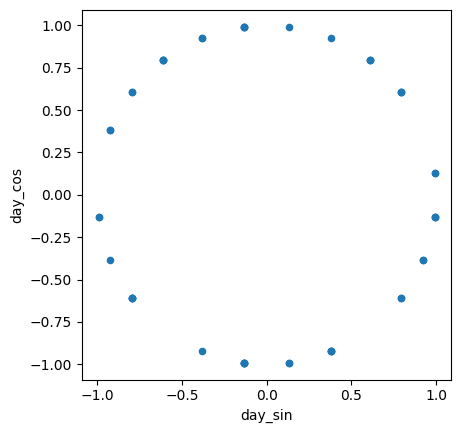

In [21]:
dataset.sample(50).plot.scatter('day_sin', 'day_cos').set_aspect('equal');

In [22]:
n = len(dataset)
train_df = dataset[0 : int(n * 0.7)]
val_df = dataset[int(n * 0.7) : int(n * 0.9)]
test_df = dataset[int(n * 0.9) : ]

In [23]:
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [24]:
class DataWindow():

    def __init__(self, input_width, label_width, shift, train_df = train_df, val_df = val_df, test_df = test_df, label_columns = None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {
                name: i for i, name in enumerate(train_df.columns)
            }

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, : ]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis = -1
            )
        inputs.set_shape([None, self.input_width, None]) 
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Hourly Demand Met (in MW)', max_subplots=3):
        inputs, labels = self.sample_batch
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k',
                        marker='s', label='Labels', c='green', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X',
                            edgecolors='k', label='Predictions', c='red', s=64)
                if n == 0:
                    plt.legend()

        plt.xlabel('Time (h)')
        plt.show()

    def make_dataset(self, data):
        data = np.array(data, dtype = np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = True,
            batch_size = 32
        )
        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [25]:
single_step_window = DataWindow(input_width = 1, label_width = 1, shift = 1, label_columns = ['Hourly Demand Met (in MW)'])

In [26]:
wide_window = DataWindow(input_width = 24, label_width = 24, shift = 1, label_columns = ['Hourly Demand Met (in MW)'])

In [27]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]  
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        results = inputs[:, :, self.label_index]
        return results[:, :, tf.newaxis]

In [28]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
baseline_last = Baseline(label_index = column_indices['Hourly Demand Met (in MW)'])

In [29]:
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [30]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test)

402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0334
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - mean_absolute_error: 0.0407


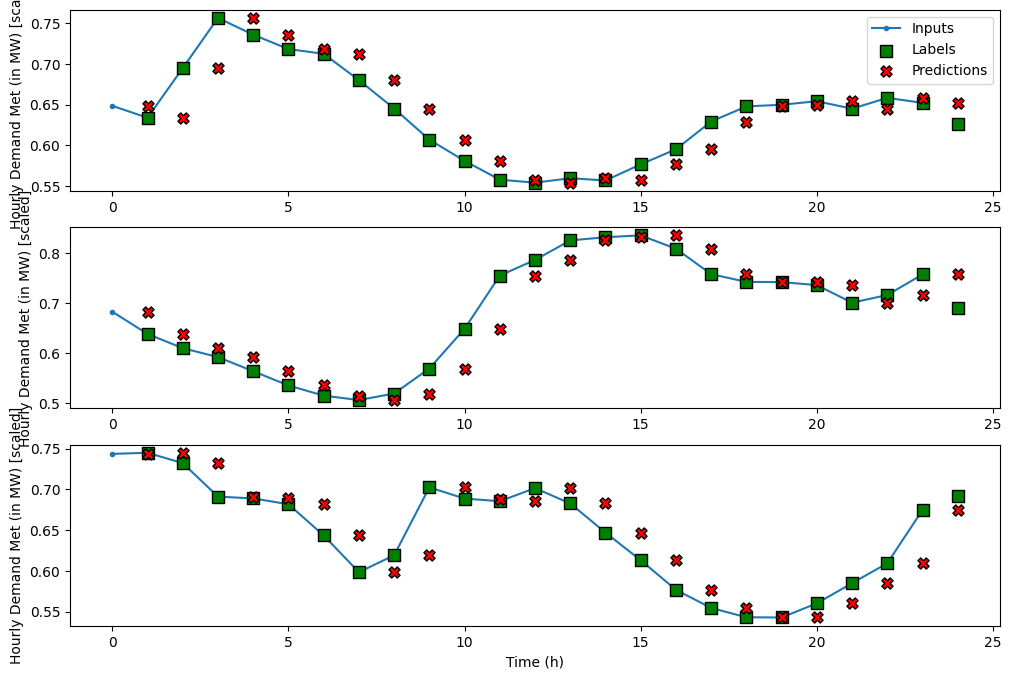

In [31]:
wide_window.plot(baseline_last)

In [32]:
multi_window = DataWindow(input_width = 24, label_width = 24, shift = 24, label_columns = ['Hourly Demand Met (in MW)'])

In [33]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [34]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['Hourly Demand Met (in MW)'])

In [35]:
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [36]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1578 - mean_absolute_error: 0.2971


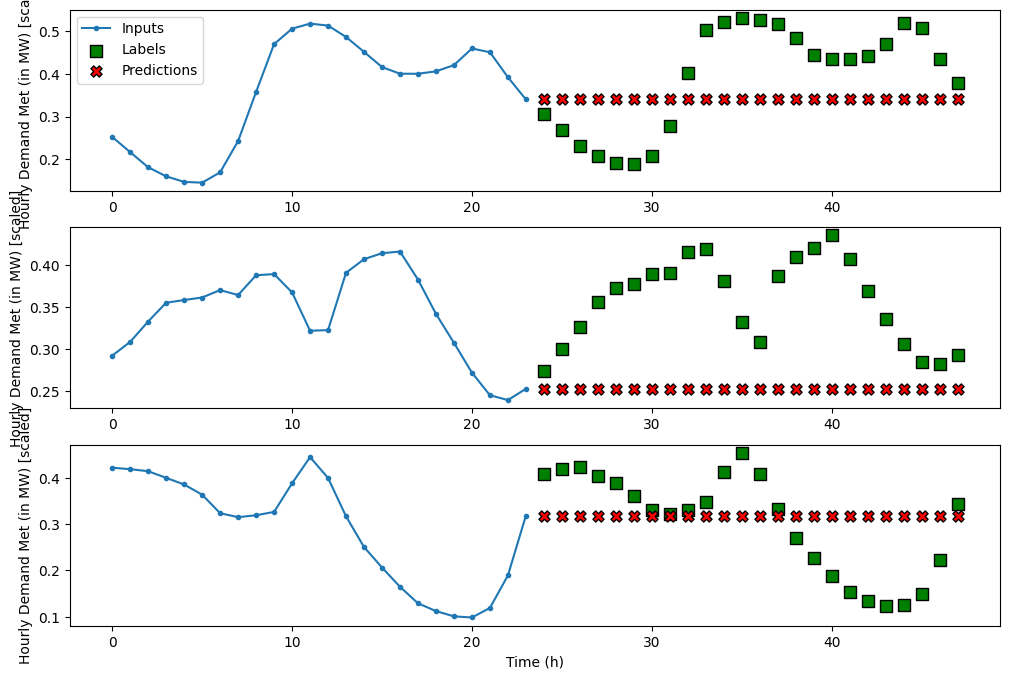

In [37]:
multi_window.plot(ms_baseline_last)

In [38]:
class RepeatBaseline(Model):
    def __init__(self, label_index = None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [39]:
ms_baseline_repeat = RepeatBaseline(label_index = column_indices['Hourly Demand Met (in MW)'])
ms_baseline_repeat.compile(loss = MeanSquaredError(), metrics = [MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1465 - mean_absolute_error: 0.2663
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1759 - mean_absolute_error: 0.2946


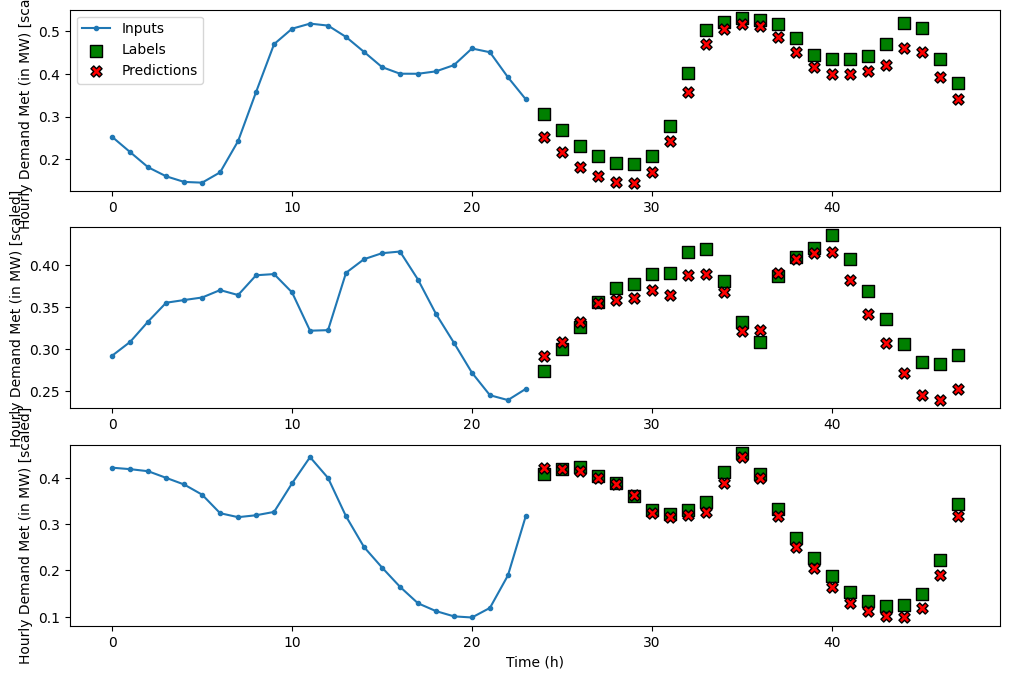

In [40]:
multi_window.plot(ms_baseline_repeat)

In [41]:
print(ms_performance['Baseline - Repeat'][1])

0.2945272922515869


In [42]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience = patience, mode='min')
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    history = model.fit(window.train, epochs = max_epochs, validation_data = window.val, callbacks = [early_stopping])
    
    return history    

In [43]:
linear = Sequential([
    Dense(units=1)
])

In [44]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0311 - mean_absolute_error: 0.1358 - val_loss: 0.0023 - val_mean_absolute_error: 0.0392
Epoch 2/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0015 - mean_absolute_error: 0.0281 - val_loss: 0.0015 - val_mean_absolute_error: 0.0286
Epoch 3/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0013 - mean_absolute_error: 0.0259 - val_loss: 0.0015 - val_mean_absolute_error: 0.0288
Epoch 4/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0260 - val_loss: 0.0015 - val_mean_absolute_error: 0.0287
Epoch 5/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0261 - val_loss: 0.0016 - val_mean_absolute_error: 0.0291


In [45]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test)

402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0292
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0340


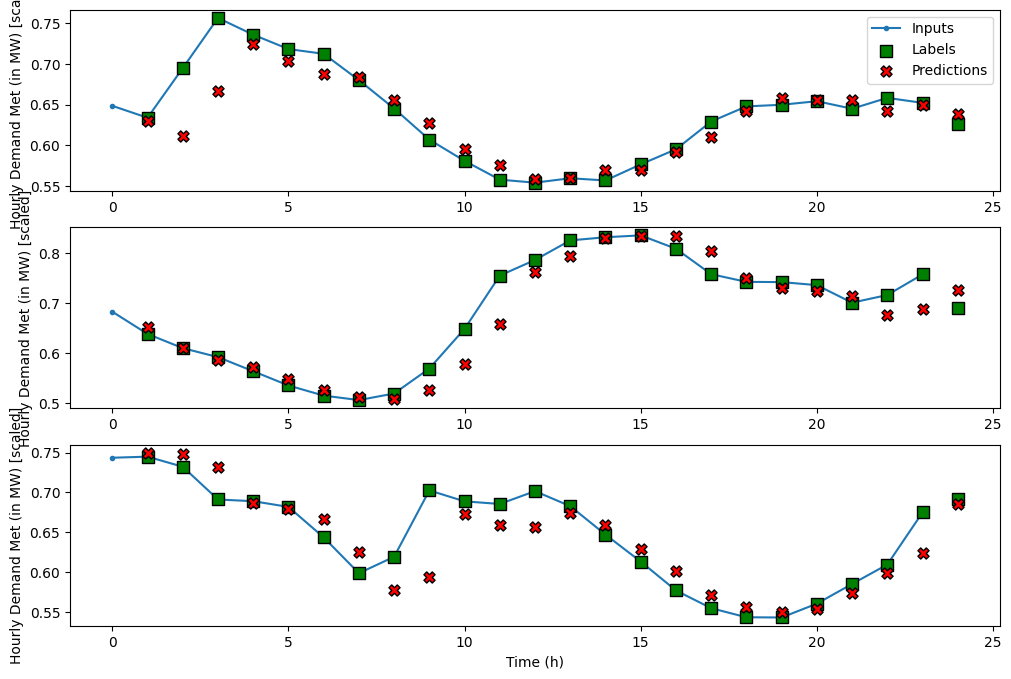

In [46]:
wide_window.plot(linear)

In [47]:
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

In [48]:
history = compile_and_fit(ms_linear, multi_window)

Epoch 1/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0684 - mean_absolute_error: 0.2005 - val_loss: 0.0324 - val_mean_absolute_error: 0.1601
Epoch 2/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0061 - mean_absolute_error: 0.0627 - val_loss: 0.0119 - val_mean_absolute_error: 0.0944
Epoch 3/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0438 - val_loss: 0.0046 - val_mean_absolute_error: 0.0548
Epoch 4/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0350 - val_loss: 0.0034 - val_mean_absolute_error: 0.0447
Epoch 5/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0337 - val_loss: 0.0033 - val_mean_absolute_error: 0.0435
Epoch 6/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0021 - mean_absolute_error: 0.0337 - val_loss: 0.0033 - val_mean_absolute_error: 0.0433
Epoch 7/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0021 - mean_absolute_err

In [49]:
ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034 - mean_absolute_error: 0.0438
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0456


In [50]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

In [51]:
dense = Sequential([
    Dense(units = 64, activation = 'relu'),
    Dense(units = 64, activation = 'relu'),
    Dense(units = 1)
])

In [52]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0340 - val_loss: 0.0020 - val_mean_absolute_error: 0.0346
Epoch 2/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.7401e-04 - mean_absolute_error: 0.0202 - val_loss: 0.0015 - val_mean_absolute_error: 0.0300
Epoch 3/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.6030e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0015 - val_mean_absolute_error: 0.0297
Epoch 4/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.2819e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0014 - val_mean_absolute_error: 0.0291
Epoch 5/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.3225e-04 - mean_absolute_error: 0.0195 - val_loss: 9.5736e-04 - val_mean_absolute_error: 0.0231
Epoch 6/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.2086e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0011 - val_mean_absolute_error: 0.0240
Epoch 7/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7.

In [53]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0283
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0367


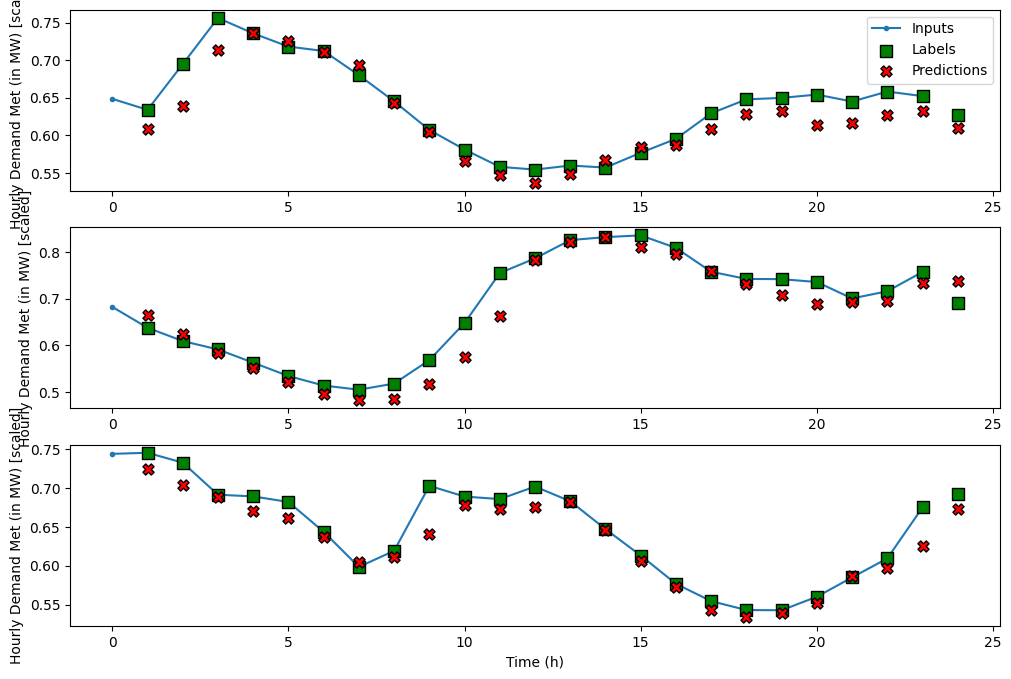

In [54]:
wide_window.plot(dense)

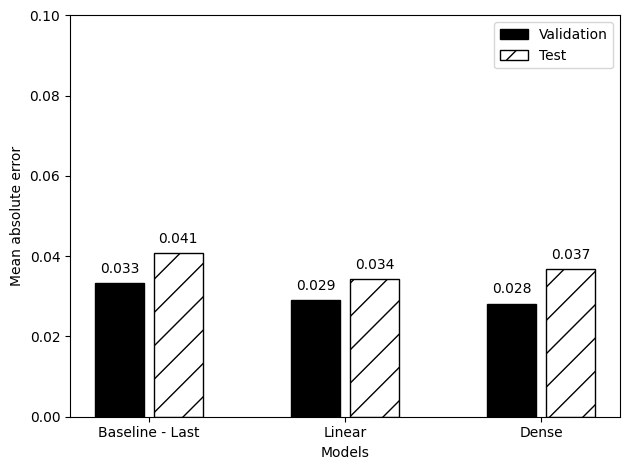

In [55]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]
x = np.arange(len(performance))
fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')
for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

In [56]:
ms_dense = Sequential([
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1, kernel_initializer = tf.initializers.zeros)
])

In [57]:
history = compile_and_fit(ms_dense, multi_window)

Epoch 1/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0764 - val_loss: 0.0038 - val_mean_absolute_error: 0.0479
Epoch 2/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0342 - val_loss: 0.0031 - val_mean_absolute_error: 0.0411
Epoch 3/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0341 - val_loss: 0.0032 - val_mean_absolute_error: 0.0415
Epoch 4/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0342 - val_loss: 0.0034 - val_mean_absolute_error: 0.0441
Epoch 5/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0342 - val_loss: 0.0031 - val_mean_absolute_error: 0.0411


In [58]:
ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0408
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0430


In [59]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

In [60]:
x = np.arange(len(ms_performance))

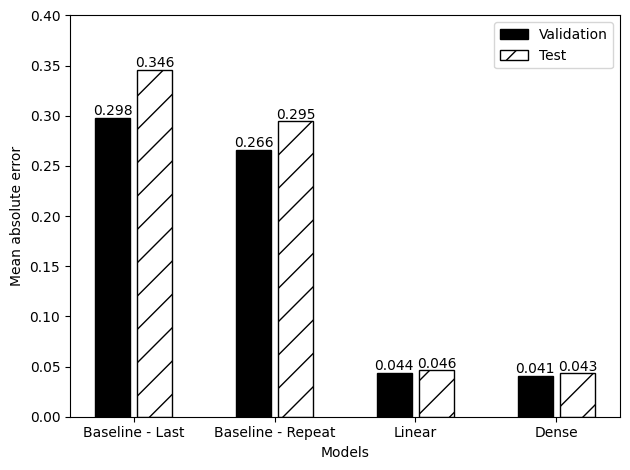

In [61]:
fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')
for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)),ha='center')
plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

In [62]:
lstm_model = Sequential([
    LSTM(32, return_sequences = True),
    Dense(units = 2)
])

In [63]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/50
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0175 - mean_absolute_error: 0.0835 - val_loss: 0.0015 - val_mean_absolute_error: 0.0276
Epoch 2/50
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 8.0632e-04 - mean_absolute_error: 0.0201 - val_loss: 8.3818e-04 - val_mean_absolute_error: 0.0208
Epoch 3/50
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 5.9888e-04 - mean_absolute_error: 0.0173 - val_loss: 8.1312e-04 - val_mean_absolute_error: 0.0205
Epoch 4/50
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 5.6203e-04 - mean_absolute_error: 0.0169 - val_loss: 7.5540e-04 - val_mean_absolute_error: 0.0198
Epoch 5/50
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 5.2241e-04 - mean_absolute_error: 0.0163 - val_loss: 6.8345e-04 - val_mean_absolute_error: 0.0189
Epoch 6/50
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 4.2605e-04 - mean_absolute_error: 0.0146 - val_loss: 7.0581e-04 - val_mean_absolute_error: 0.0193
Epoch 7/50
1405/1405 ━━━━━━━━━━━━━━━━━

In [64]:
val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6879e-04 - mean_absolute_error: 0.0154
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3980e-04 - mean_absolute_error: 0.0183


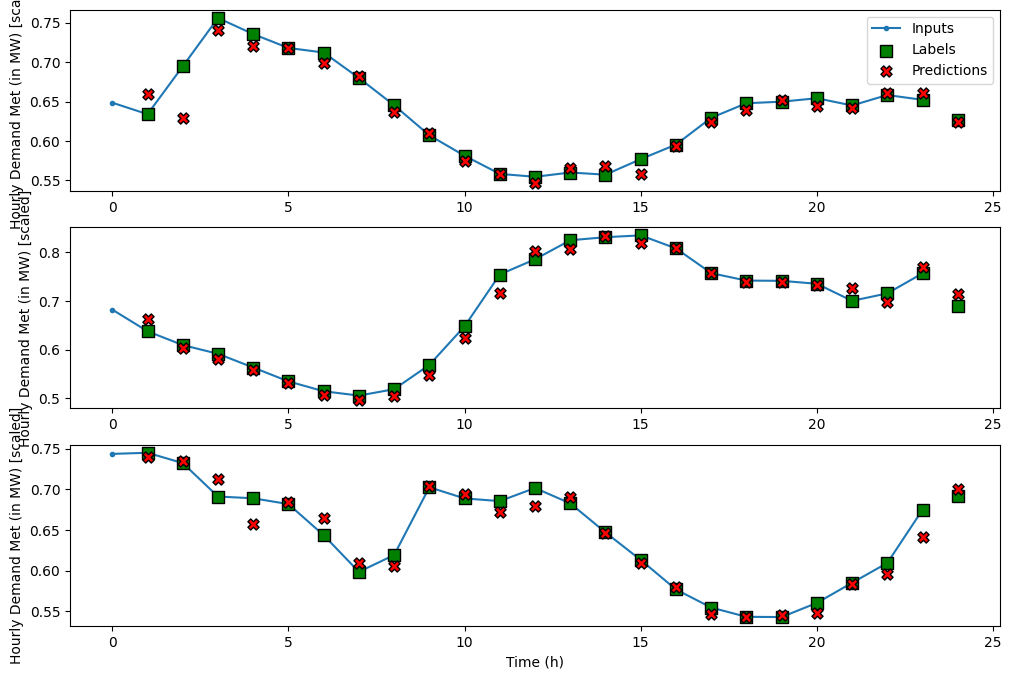

In [65]:
wide_window.plot(lstm_model)

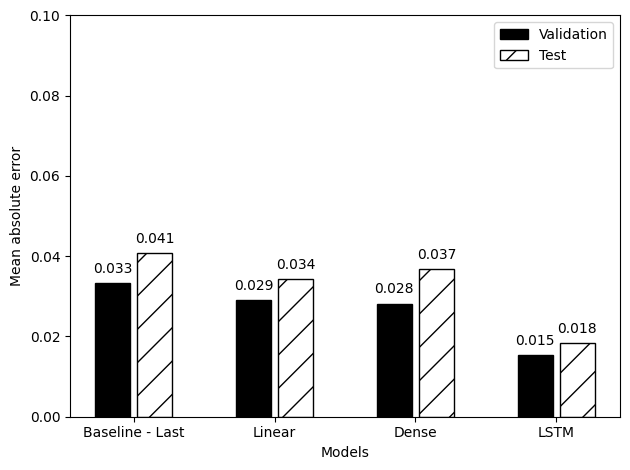

In [66]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

In [67]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences = True),
    Dense(1, kernel_initializer = tf.initializers.zeros)
])

In [68]:
history = compile_and_fit(ms_lstm_model, multi_window)

Epoch 1/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0341 - mean_absolute_error: 0.1241 - val_loss: 0.0056 - val_mean_absolute_error: 0.0567
Epoch 2/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0025 - mean_absolute_error: 0.0369 - val_loss: 0.0038 - val_mean_absolute_error: 0.0460
Epoch 3/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0022 - mean_absolute_error: 0.0348 - val_loss: 0.0036 - val_mean_absolute_error: 0.0454
Epoch 4/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0022 - mean_absolute_error: 0.0342 - val_loss: 0.0042 - val_mean_absolute_error: 0.0513
Epoch 5/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0021 - mean_absolute_error: 0.0339 - val_loss: 0.0034 - val_mean_absolute_error: 0.0446
Epoch 6/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0021 - mean_absolute_error: 0.0337 - val_loss: 0.0033 - val_mean_absolute_error: 0.0429
Epoch 7/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0021 - mean_abso

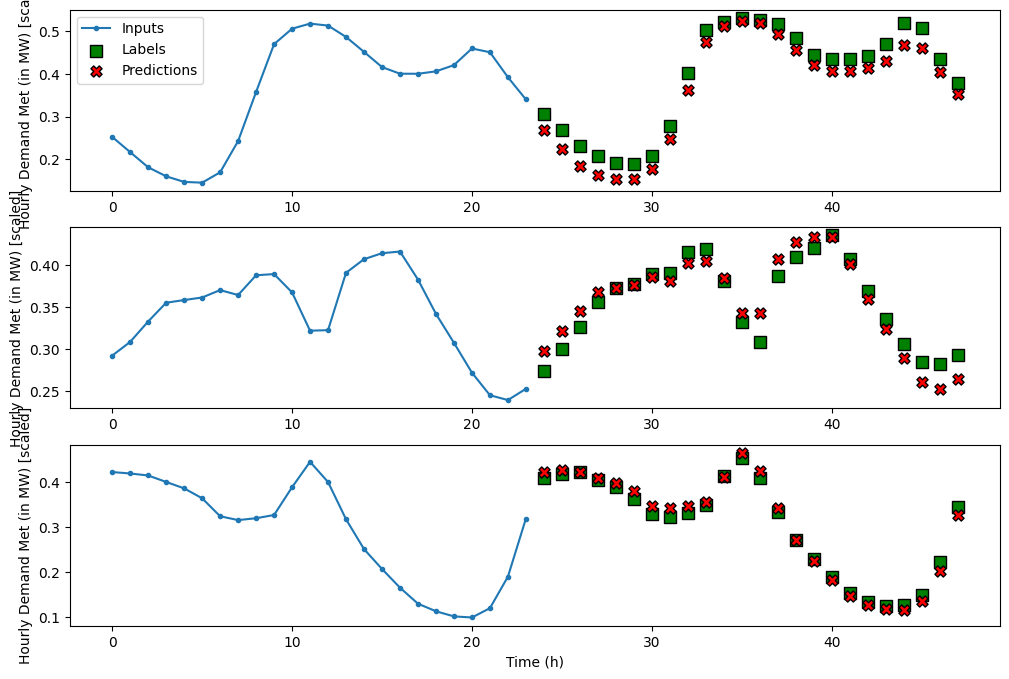

In [69]:
multi_window.plot(ms_lstm_model)

In [70]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0473
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - mean_absolute_error: 0.0520


In [71]:
ms_mae_val

[0.2982644736766815,
 0.2663235664367676,
 0.04367600008845329,
 0.041064269840717316]

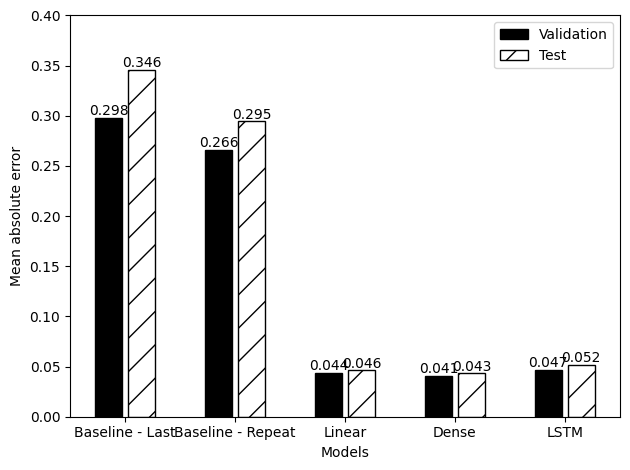

In [72]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

In [73]:
KERNEL_WIDTH = 3

In [74]:
conv_window = DataWindow(input_width = KERNEL_WIDTH, label_width = 1, shift = 1, label_columns = ['Hourly Demand Met (in MW)'])

In [75]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1
wide_conv_window = DataWindow(input_width = INPUT_WIDTH, label_width = LABEL_WIDTH, shift = 1, label_columns = ['Hourly Demand Met (in MW)'])

In [76]:
cnn_model = Sequential([
    Conv1D(filters = 32, kernel_size = (KERNEL_WIDTH,),
          activation = 'relu'),
    Dense(units = 32, activation = 'relu'),
    Dense(units = 1)
])

In [77]:
history = compile_and_fit(cnn_model, conv_window)

Epoch 1/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0038 - mean_absolute_error: 0.0402 - val_loss: 0.0015 - val_mean_absolute_error: 0.0290
Epoch 2/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.8737e-04 - mean_absolute_error: 0.0175 - val_loss: 8.2724e-04 - val_mean_absolute_error: 0.0198
Epoch 3/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.7217e-04 - mean_absolute_error: 0.0158 - val_loss: 6.6917e-04 - val_mean_absolute_error: 0.0180
Epoch 4/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.0413e-04 - mean_absolute_error: 0.0147 - val_loss: 6.2852e-04 - val_mean_absolute_error: 0.0182
Epoch 5/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.6903e-04 - mean_absolute_error: 0.0141 - val_loss: 5.9715e-04 - val_mean_absolute_error: 0.0182
Epoch 6/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.3974e-04 - mean_absolute_error: 0.0136 - val_loss: 8.6806e-04 - val_mean_absolute_error: 0.0232
Epoch 7/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms

In [78]:
val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test)

402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7556e-04 - mean_absolute_error: 0.0156
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7897e-04 - mean_absolute_error: 0.0192


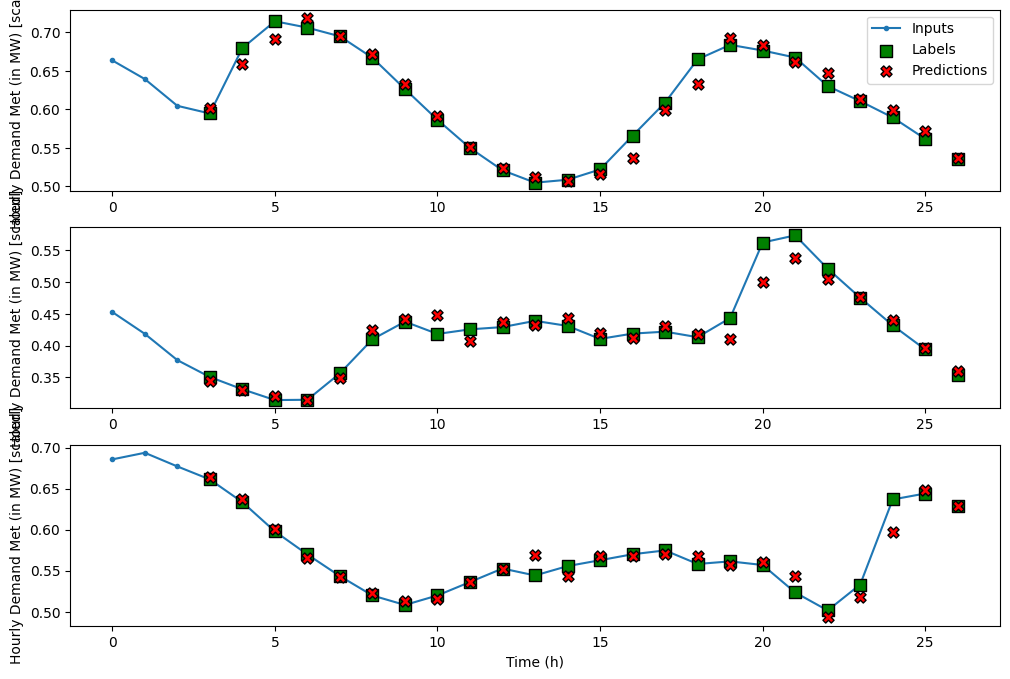

In [79]:
wide_conv_window.plot(cnn_model)

In [80]:
cnn_lstm_model = Sequential([
    Conv1D(
        filters = 32,
        kernel_size = (KERNEL_WIDTH),
        activation = 'relu'
    ),
    LSTM(32, return_sequences = True),
    LSTM(32, return_sequences = True),
    Dense(1)
])

In [81]:
history = compile_and_fit(cnn_lstm_model, conv_window)

Epoch 1/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0242 - mean_absolute_error: 0.0845 - val_loss: 0.0014 - val_mean_absolute_error: 0.0277
Epoch 2/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 8.1779e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0012 - val_mean_absolute_error: 0.0251
Epoch 3/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.4697e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0011 - val_mean_absolute_error: 0.0252
Epoch 4/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 5.5764e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0013 - val_mean_absolute_error: 0.0260
Epoch 5/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.0549e-04 - mean_absolute_error: 0.0163 - val_loss: 7.9480e-04 - val_mean_absolute_error: 0.0191
Epoch 6/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.4655e-04 - mean_absolute_error: 0.0152 - val_loss: 9.5631e-04 - val_mean_absolute_error: 0.0220
Epoch 7/50
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss

In [82]:
val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test)

402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0313e-04 - mean_absolute_error: 0.0198
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0258


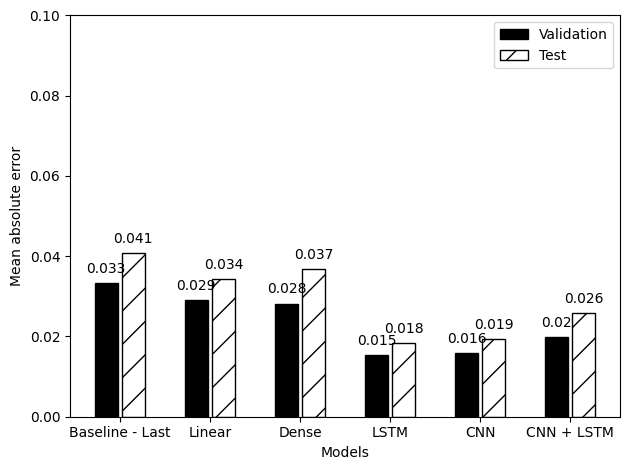

In [83]:
mae_val.append(val_performance['CNN'][1])
mae_test.append(performance['CNN'][1])
mae_val.append(val_performance['CNN + LSTM'][1])
mae_test.append(performance['CNN + LSTM'][1])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

In [84]:
multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Hourly Demand Met (in MW)'])

In [85]:
ms_cnn_model = Sequential([
    Conv1D(32, activation = 'relu', kernel_size = (KERNEL_WIDTH)),
    Dense(32, activation = 'relu'),
    Dense(1, kernel_initializer = tf.initializers.zeros)
])

In [86]:
history = compile_and_fit(ms_cnn_model, multi_window)

Epoch 1/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0241 - mean_absolute_error: 0.0867 - val_loss: 0.0035 - val_mean_absolute_error: 0.0450
Epoch 2/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0344 - val_loss: 0.0035 - val_mean_absolute_error: 0.0453
Epoch 3/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0344 - val_loss: 0.0039 - val_mean_absolute_error: 0.0491
Epoch 4/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0342 - val_loss: 0.0043 - val_mean_absolute_error: 0.0529


In [87]:
ms_val_performance = {}
performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0531
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - mean_absolute_error: 0.0579


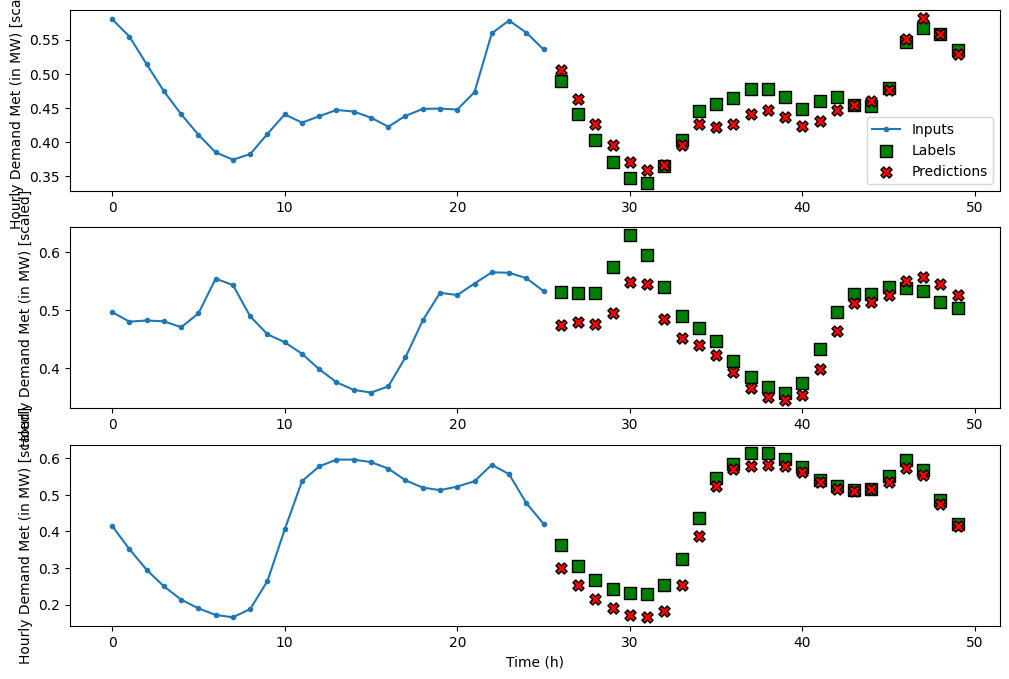

In [88]:
multi_window.plot(ms_cnn_model)

In [89]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [90]:
history = compile_and_fit(ms_cnn_lstm_model, multi_window)

Epoch 1/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0260 - mean_absolute_error: 0.0985 - val_loss: 0.0052 - val_mean_absolute_error: 0.0580
Epoch 2/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0023 - mean_absolute_error: 0.0354 - val_loss: 0.0044 - val_mean_absolute_error: 0.0524
Epoch 3/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0022 - mean_absolute_error: 0.0345 - val_loss: 0.0037 - val_mean_absolute_error: 0.0468
Epoch 4/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0022 - mean_absolute_error: 0.0345 - val_loss: 0.0037 - val_mean_absolute_error: 0.0467
Epoch 5/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0022 - mean_absolute_error: 0.0344 - val_loss: 0.0041 - val_mean_absolute_error: 0.0503
Epoch 6/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0022 - mean_absolute_error: 0.0344 - val_loss: 0.0034 - val_mean_absolute_error: 0.0444
Epoch 7/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0022 - mean_abs

In [91]:
ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0036 - mean_absolute_error: 0.0466


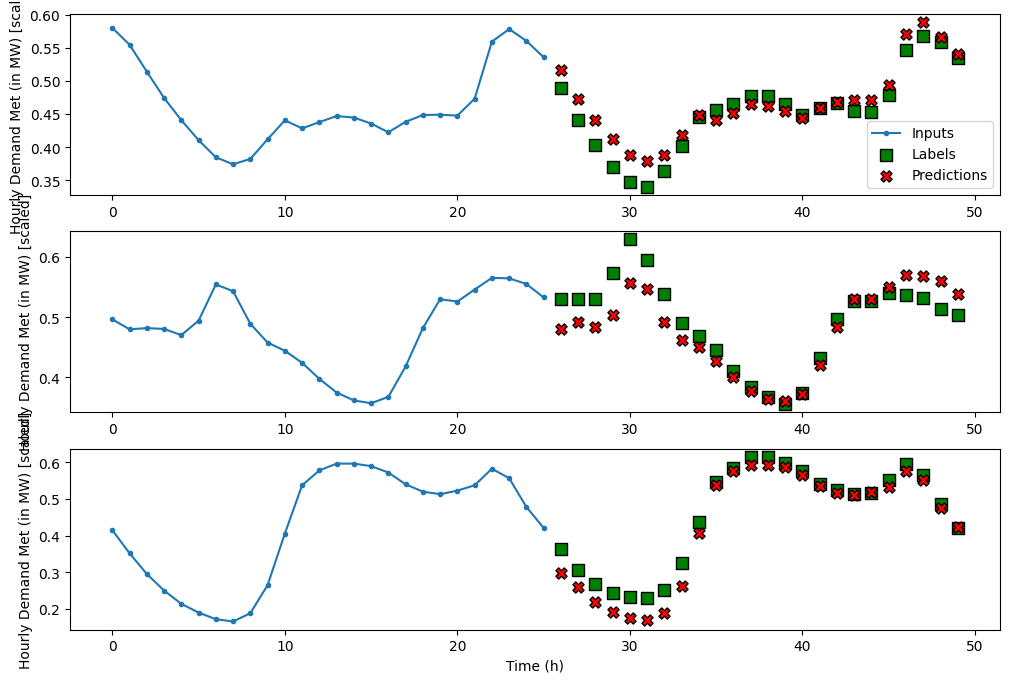

In [92]:
multi_window.plot(ms_cnn_lstm_model)

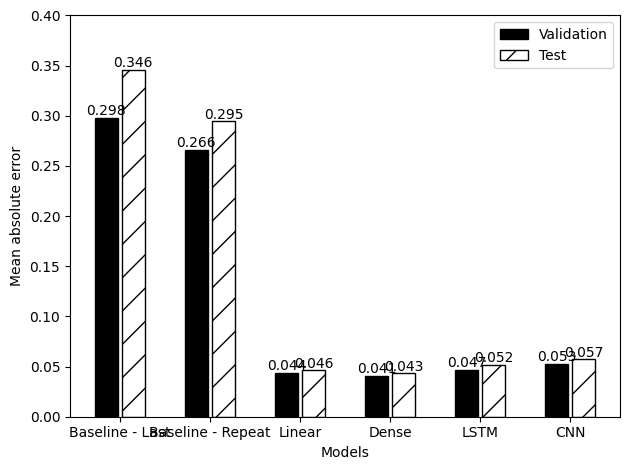

In [93]:
ms_mae_val.append(ms_val_performance['CNN'][1])
ms_mae_test.append(ms_performance['CNN'][1])

x = np.arange(6)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

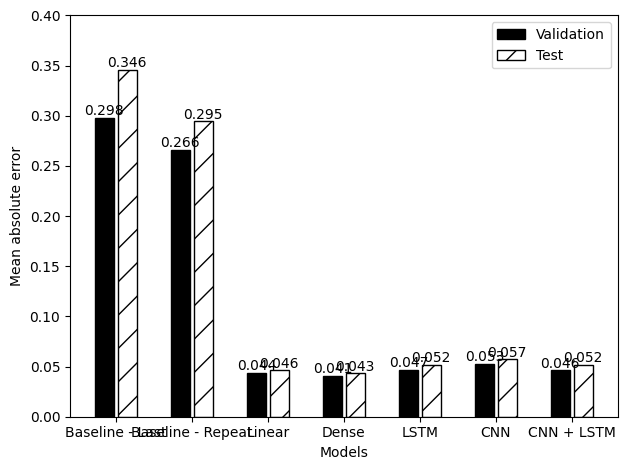

In [94]:
ms_mae_val.append(ms_val_performance['CNN + LSTM'][1])
ms_mae_test.append(ms_performance['CNN + LSTM'][1])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

In [95]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Hourly Demand Met (in MW)'])

In [96]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        
        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
            
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [97]:
AR_LSTM = AutoRegressive(units = 32, out_steps = 24)

In [98]:
history = compile_and_fit(AR_LSTM, multi_window)

Epoch 1/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0264 - mean_absolute_error: 0.1076 - val_loss: 0.0072 - val_mean_absolute_error: 0.0676
Epoch 2/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.0035 - mean_absolute_error: 0.0458 - val_loss: 0.0055 - val_mean_absolute_error: 0.0588
Epoch 3/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0025 - mean_absolute_error: 0.0386 - val_loss: 0.0050 - val_mean_absolute_error: 0.0560
Epoch 4/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0024 - mean_absolute_error: 0.0370 - val_loss: 0.0039 - val_mean_absolute_error: 0.0485
Epoch 5/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0023 - mean_absolute_error: 0.0361 - val_loss: 0.0054 - val_mean_absolute_error: 0.0583
Epoch 6/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0022 - mean_absolute_error: 0.0355 - val_loss: 0.0057 - val_mean_absolute_error: 0.0599
Epoch 7/50
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - loss: 0.0022 - mea

In [99]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0534


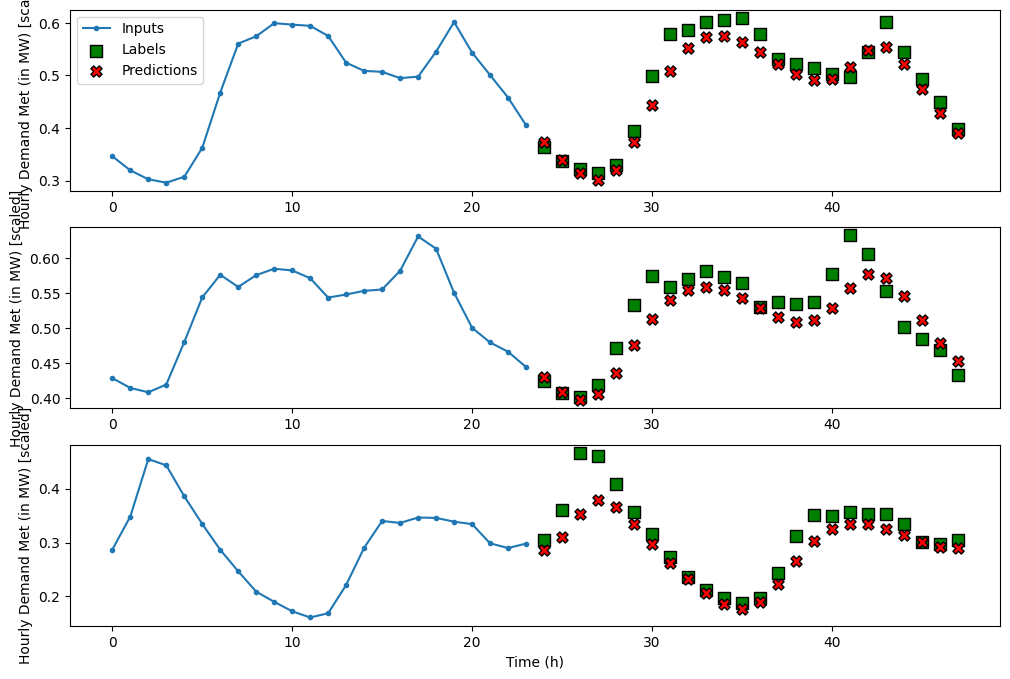

In [100]:
multi_window.plot(AR_LSTM)

In [133]:
dataset.columns

Index(['ds', 'y'], dtype='object')

In [134]:
dataset.columns = ['ds', 'y']

In [135]:
n = len(dataset)
train_df = dataset[0 : int(n * 0.8)]
test_df = dataset[int(n * 0.8) : ]

In [136]:
len(train_df), len(test_df)

(51398, 12850)

In [137]:
m = Prophet()

In [138]:
m.fit(train_df)

17:21:57 - cmdstanpy - INFO - Chain [1] start processing
17:22:43 - cmdstanpy - INFO - Chain [1] done processing


In [156]:
future = m.make_future_dataframe(periods=12850, freq='H')

In [157]:
forecast = m.predict(future)

In [158]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01 00:00:00,136139.614874,101910.083538,126760.553292,136139.614874,136139.614874,-21492.646182,-21492.646182,-21492.646182,-6290.790904,...,-2179.485682,-2179.485682,-2179.485682,-13022.369596,-13022.369596,-13022.369596,0.0,0.0,0.0,114646.968691
1,2017-01-01 01:00:00,136133.346251,98690.039655,123252.046754,136133.346251,136133.346251,-24833.196243,-24833.196243,-24833.196243,-9358.943882,...,-2456.475015,-2456.475015,-2456.475015,-13017.777347,-13017.777347,-13017.777347,0.0,0.0,0.0,111300.150008
2,2017-01-01 02:00:00,136127.077628,96041.870111,121134.225203,136127.077628,136127.077628,-27833.344138,-27833.344138,-27833.344138,-12090.810362,...,-2729.310672,-2729.310672,-2729.310672,-13013.223103,-13013.223103,-13013.223103,0.0,0.0,0.0,108293.733490
3,2017-01-01 03:00:00,136120.809005,94501.114789,118948.788006,136120.809005,136120.809005,-29630.825717,-29630.825717,-29630.825717,-13626.336066,...,-2995.783085,-2995.783085,-2995.783085,-13008.706567,-13008.706567,-13008.706567,0.0,0.0,0.0,106489.983287
4,2017-01-01 04:00:00,136114.540382,93454.626911,118560.759357,136114.540382,136114.540382,-29148.793163,-29148.793163,-29148.793163,-12890.865846,...,-3253.699879,-3253.699879,-3253.699879,-13004.227438,-13004.227438,-13004.227438,0.0,0.0,0.0,106965.747219


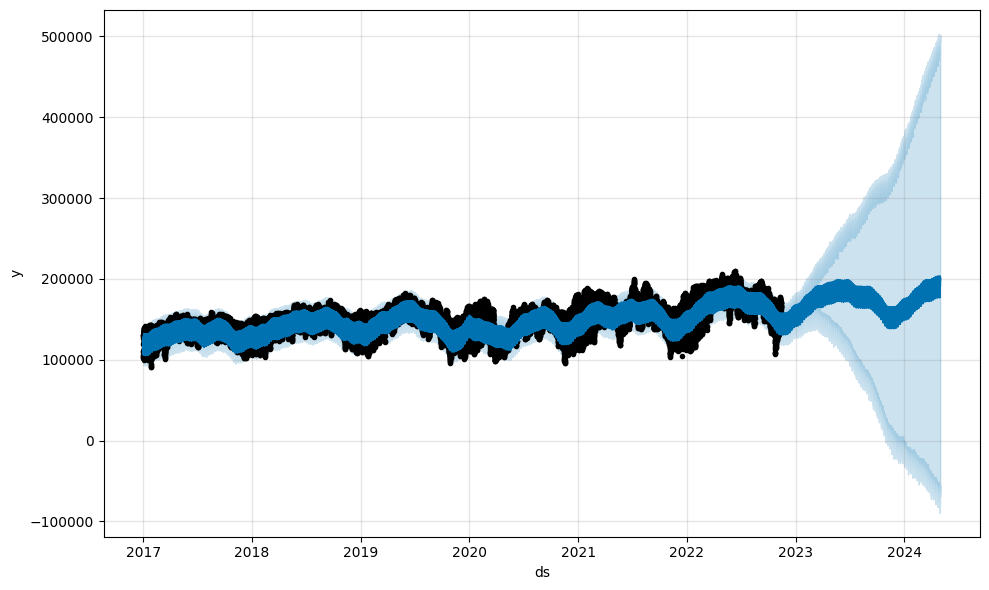

In [159]:
fcst = m.predict(future)
fig = m.plot(fcst)

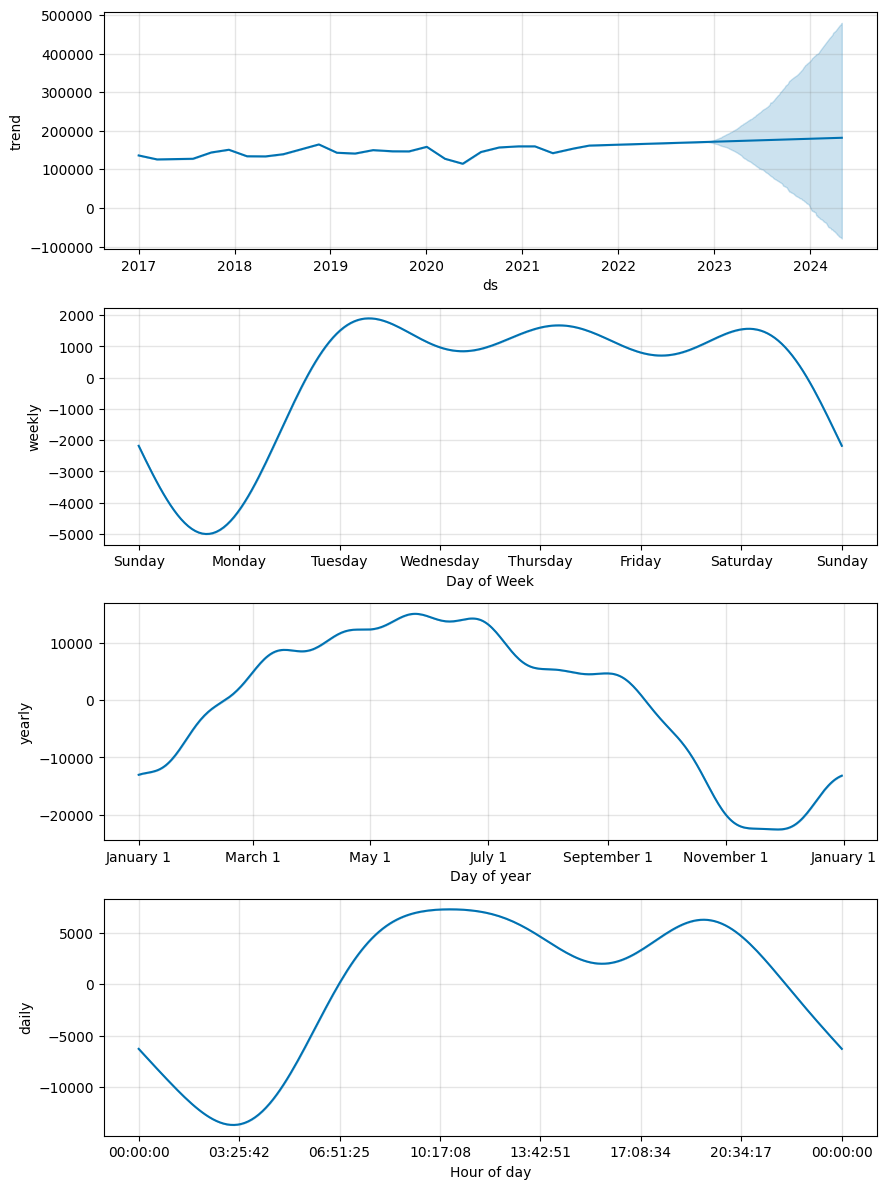

In [160]:
fig = m.plot_components(fcst)

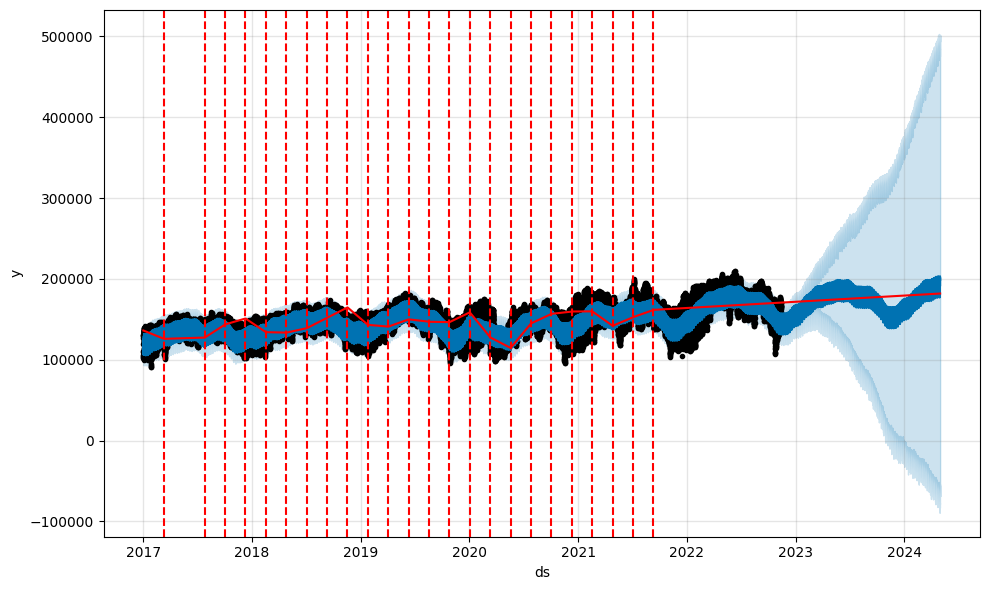

In [161]:
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)